## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'erb-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_erb_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\erb\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


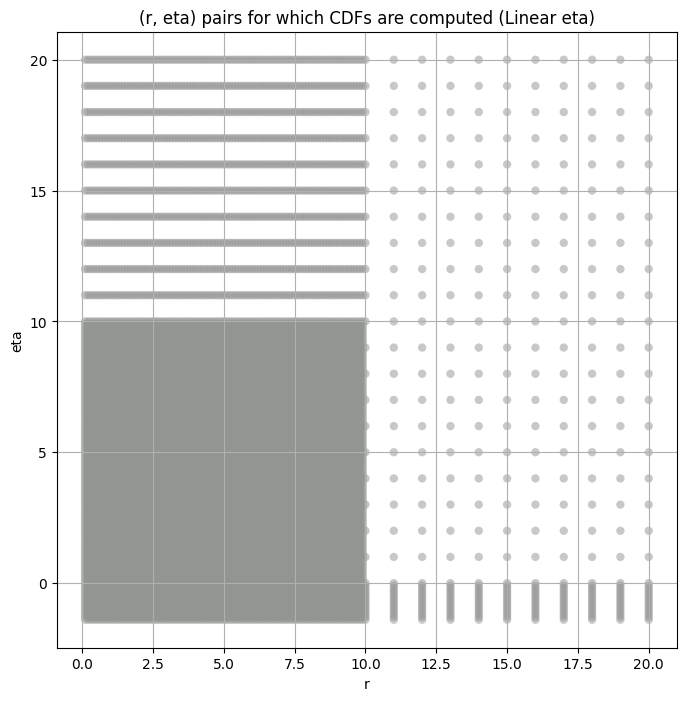

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 12


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 16


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013248   0.011009   0.016009   50.686798   24.662481   80.691333   
3     0.217878   0.182872   0.256856   41.428048   32.659045   52.120117   
5     2.125072   1.956127   2.298965    7.871349    6.856903    8.984187   
6     1.606098   1.478197   1.737453    7.848421    6.962206    8.786270   
8     0.153044   0.133159   0.176189   27.853211   17.169534   43.255178   
9     0.036976   0.032702   0.042352   22.968292   11.510382   58.350382   
11    0.023980   0.020239   0.028227   38.853401   27.311376   60.455321   
12    0.010856   0.008917   0.013248   56.908062   35.399686  112.468374   
14    0.000619   0.000499   0.000804   83.300207   35.923712  272.975980   
16    0.000157   0.000108   0.000229  217.463133   92.127912  521.275303   

      total_samples  
band                 
2          100000.0  
3          100000.0  
5          100000.0  
6          100000.0  
8          100000.0  
9          100000.0  
11         100000.0  
12         100000.0  
14         100000.0  
16         100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.013248       0.013248        0.011679        0.010882        0.010315   
3     0.217878       0.217878        0.201274        0.189505        0.179717   
5     2.125072       2.125072        2.077960        2.039922        2.005827   
6     1.606098       1.606098        1.574112        1.546596        1.521500   
8     0.153044       0.153044        0.141368        0.134750        0.129641   
9     0.036976       0.036976        0.034425        0.033176        0.032225   
11    0.023980       0.023980        0.022012        0.020808        0.019842   
12    0.010856       0.010856        0.009706        0.009063        0.008560   
14    0.000619       0.000619        0.000543        0.000507        0.000478   
16    0.000157       0.000157        0.000119        0.000103        0.000092   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.009879         0.009238         0.008766         0.008388   
3            0.171312         0.157015         0.145036         0.134971   
5            1.974448         1.917525         1.866353         1.819575   
6            1.498186         1.455530         1.417176         1.381937   
8            0.125414         0.118557         0.113040         0.108389   
9            0.031433         0.030133         0.029064         0.028140   
11           0.019021         0.017652         0.016526         0.015564   
12           0.008138         0.007446         0.006887         0.006417   
14           0.000454         0.000415         0.000384         0.000358   
16           0.000083         0.000070         0.000060         0.000053   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.008073         0.007801         0.007147  
3            0.126417         0.118959         0.100981  
5            1.776213         1.735785         1.628279  
6            1.349208         1.318491         1.236044  
8            0.104347         0.100757         0.091935  
9            0.027320         0.026580         0.024692  
11           0.014724         0.013977         0.012143  
12           0.006011         0.005654         0.004794  
14           0.000335         0.000315         0.000267  
16           0.000047         0.000042         0.000031

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.00576194567488747 0.013247940982330456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.004014732324095882 0.011679235553679407


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.005534396628596977 0.01088155901400891


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.006571085892342565 0.010314777838478348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.004544608157883712 0.009878767925443318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0022888099429409304 0.009237692443100963


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0029990980691356906 0.00876629713802712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.003972790658925314 0.00838778954932304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.005381818471361932 0.008073185139285273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.0057773999692802835 0.0078013530987992635


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007246346575968794 0.007146619760233219
Number of samples: 100000, Without approximation : 100000.0


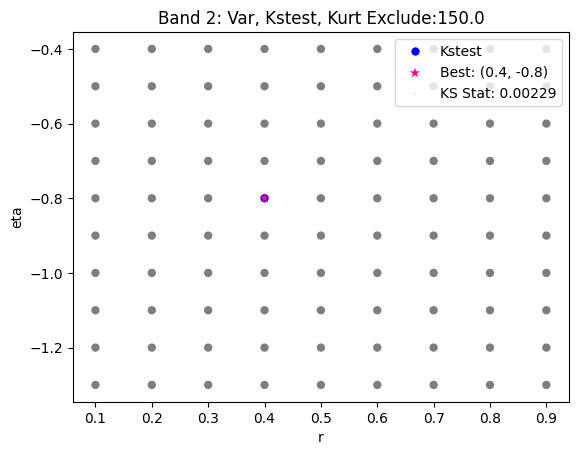

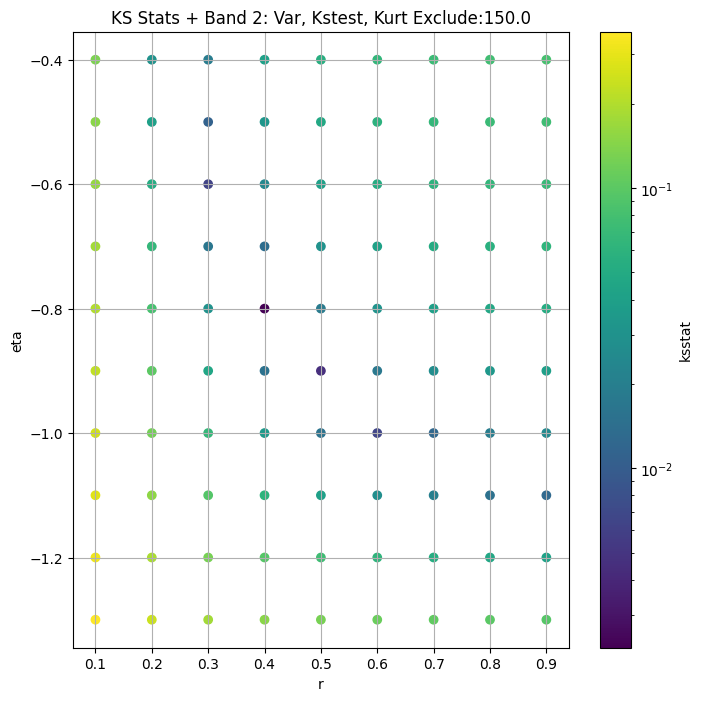

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.024314583984091143 0.21787815323246687


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.020371118643783936 0.20127409875278637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.017391539294896452 0.1895046169183034


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.016368536513129528 0.1797169243691634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.017710669293987957 0.17131203852359025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.020399682939438446 0.15701477889718138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.01919963385084722 0.1450362056142682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.015484798010024337 0.13497104744500588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.015477580605330634 0.1264174387709751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.016363355015885348 0.11895921358489049


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.017410626759627047 0.1009809274606426
Number of samples: 100000, Without approximation : 100000.0


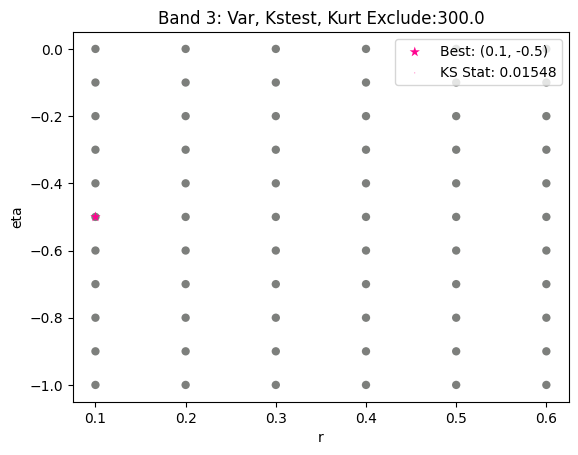

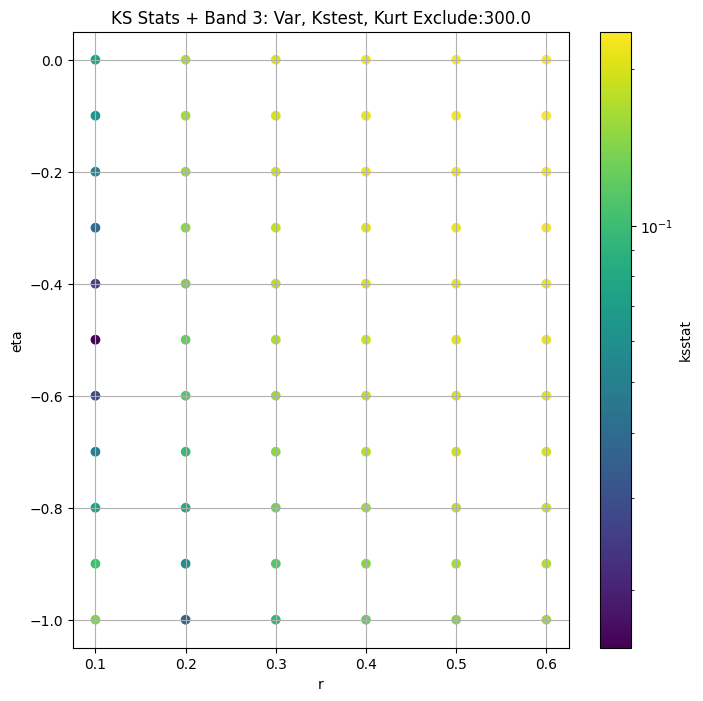

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011869850967975784 2.1250723130795306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.012351336346434039 2.077960425165075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011525567734000042 2.039922340806598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.01078425433584862 2.005827354823554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010411111389656946 1.9744475548235993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011751066594285861 1.9175253624847275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012992039847673734 1.8663530544086877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.013472070961545124 1.8195745433700492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.012408176584105868 1.7762132454878112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013164443712501209 1.7357851230761245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01388731306805742 1.6282790004091052
Number of samples: 100000, Without approximation : 100000.0


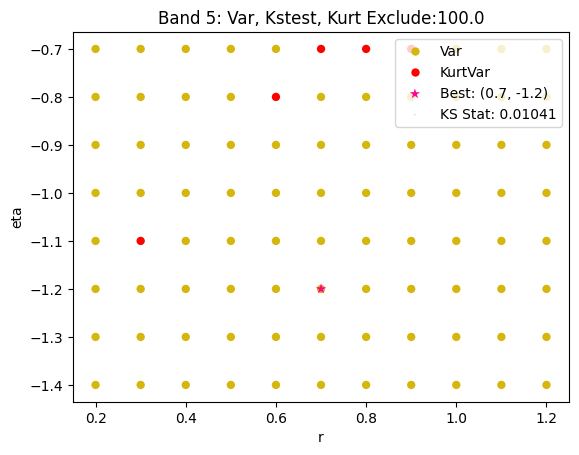

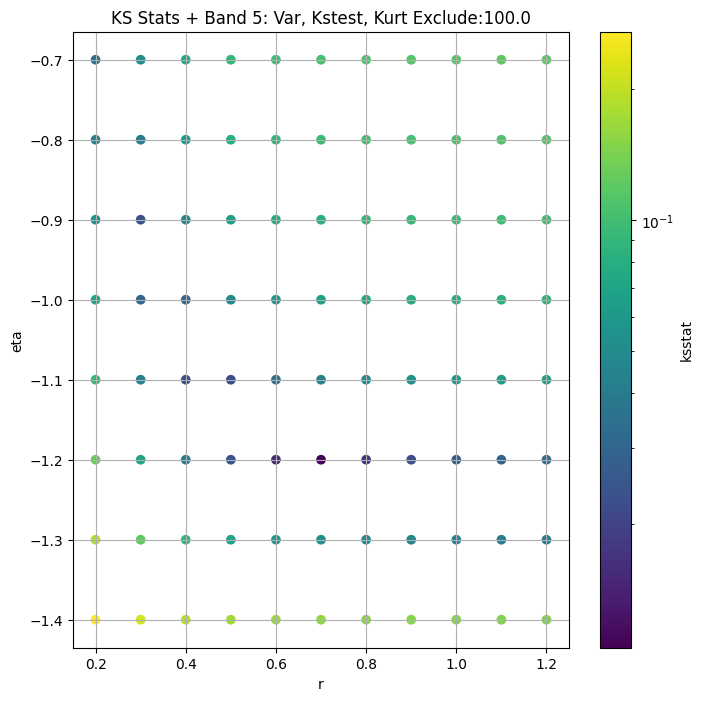

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011241847951715844 1.6060981823861697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01149626582828922 1.5741116977454819


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011723173954211685 1.5465964575812383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011934640876512914 1.5215001538243327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.012136229344713534 1.4981864128365805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.013009009583059825 1.455530016676617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.014053636160730562 1.4171759555027312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.013144085519824156 1.3819372831697376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.012918647851842796 1.349207864088077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013786892621335804 1.3184905225252643


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.0150784681246946 1.2360444148339136
Number of samples: 100000, Without approximation : 100000.0


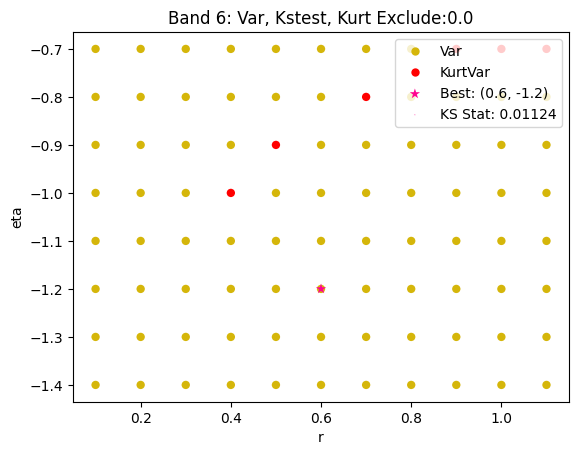

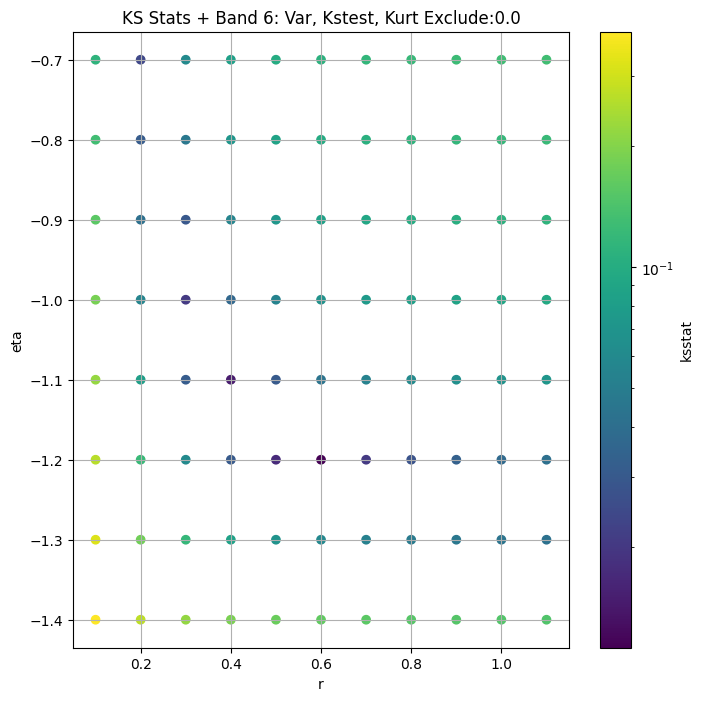

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.003845205209591529 0.1530443556291902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.005899133587670025 0.14136788759246646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005607957976204614 0.13475030997096363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.003979680846395994 0.12964128983679696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005154348744451698 0.12541395127888666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008105927454390385 0.11855668556007833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006677033579190805 0.11304037651246869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004531294675706982 0.10838864909375097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006114312875883675 0.10434735939167641


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007749297304885369 0.1007568372874216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00887888245996881 0.09193519074158328
Number of samples: 100000, Without approximation : 100000.0


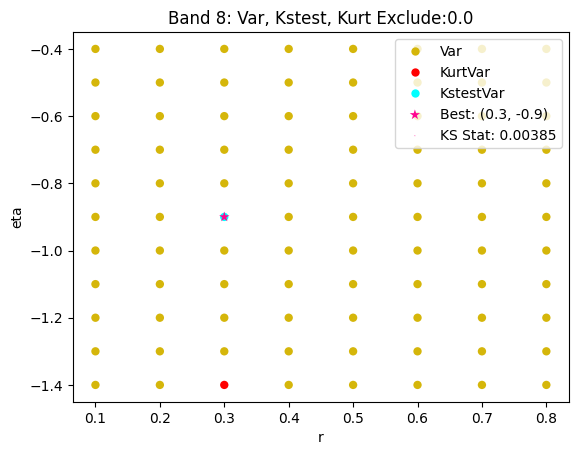

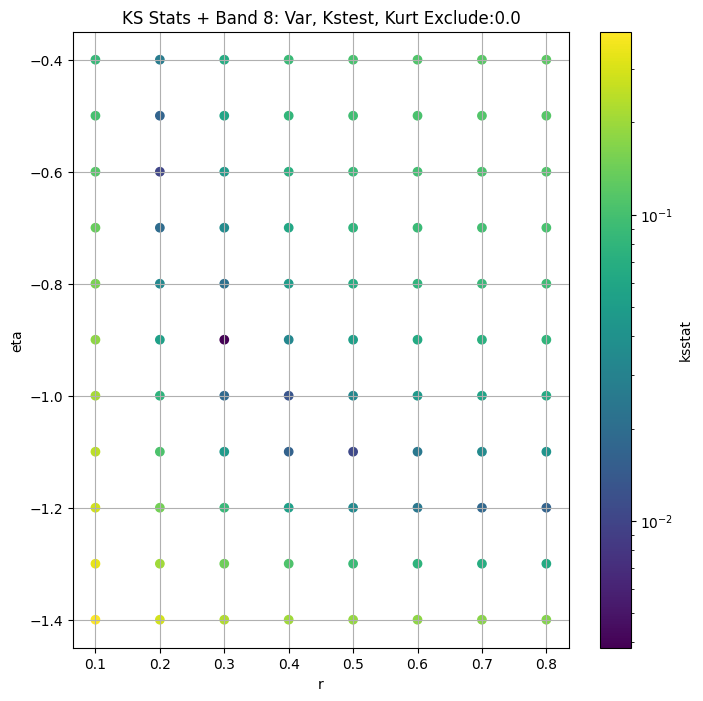

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.004058876984169707 0.03697601450676882


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.005353429730096337 0.034425149781486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.0031499856808854254 0.03317642299092878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.003467990961441847 0.032224869074275804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.003949213223396933 0.03143290924140905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005766431535199235 0.030133390737745826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005374185747086591 0.029063709831114354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.006160105555450129 0.028139953900818037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.007305541747267066 0.02732041666358702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.007868547155725159 0.02657955409763778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009503400248571214 0.024692078427654914
Number of samples: 100000, Without approximation : 100000.0


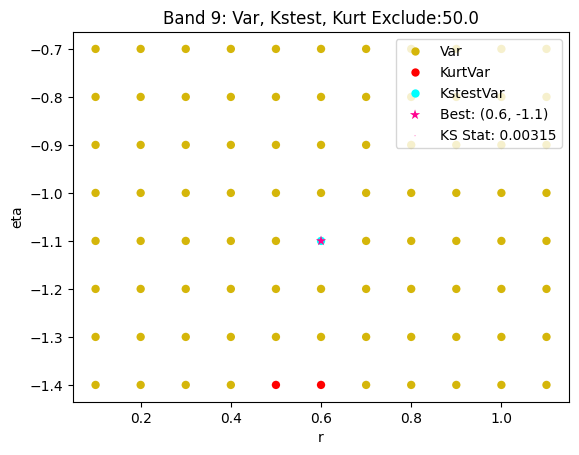

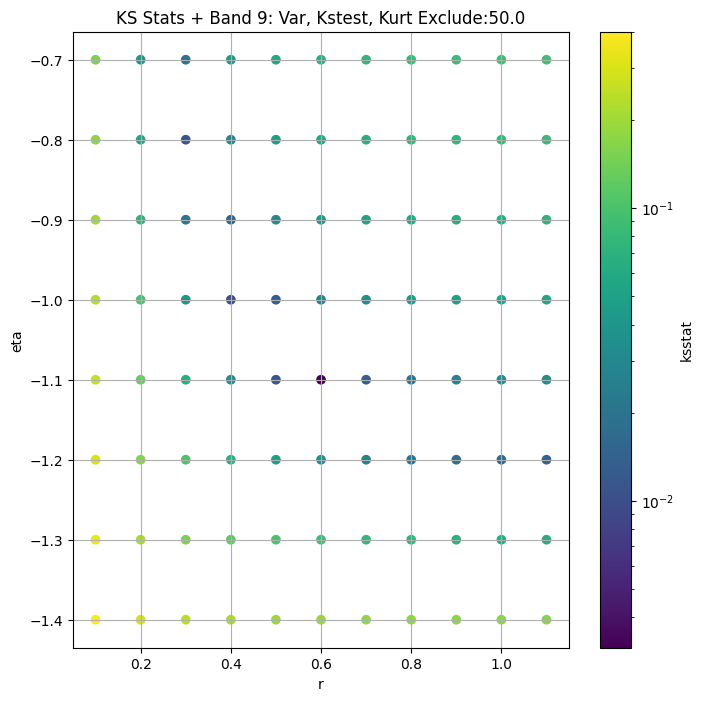

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.008884891097308056 0.023979804084388177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.00869716286708222 0.022012122562690677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.009523985712317662 0.02080757687804678


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.010264763340626093 0.01984249196872149


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.010963764236770257 0.019020752609091956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.012313236938651051 0.017651633069802487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.013644118811927841 0.01652635449948047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.01495467920764676 0.015564209717426948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.012827541468250825 0.014723862620656466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.011641472235688115 0.013977370198104702


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011315180611592097 0.012142991168564607
Number of samples: 100000, Without approximation : 100000.0


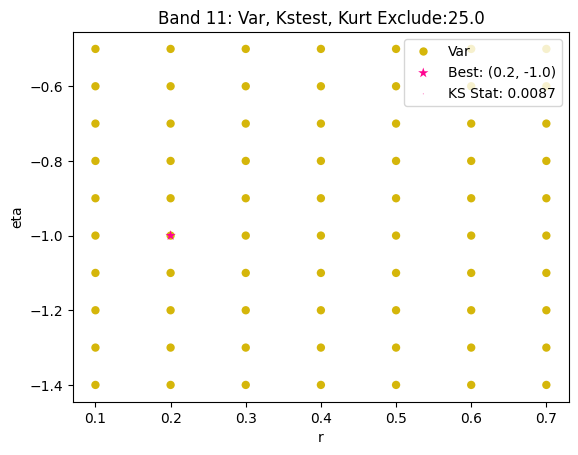

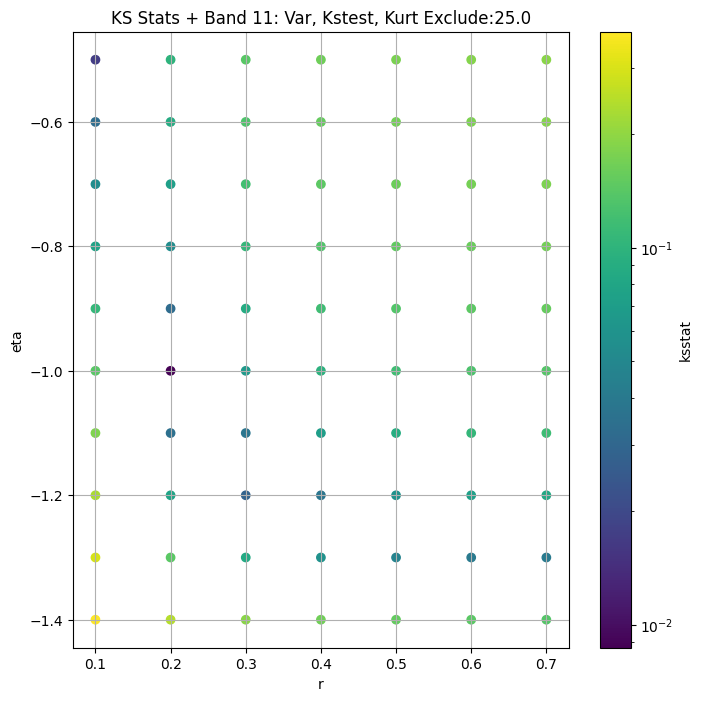

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.013516831927980089 0.010855534648658354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.010345591859708958 0.009706071639328654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.008414846206078679 0.009063220581702504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.009313963214723109 0.00856017818153234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.010145731795214694 0.008138208714098046


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.010899062707095175 0.00744579971025966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.011240330393718086 0.006886979042638762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.01245290719482444 0.0064166447123229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.01300323468680653 0.0060105845266087395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.013175361122087316 0.005654014209883746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.015477628782481379 0.004793736605704752
Number of samples: 100000, Without approximation : 100000.0


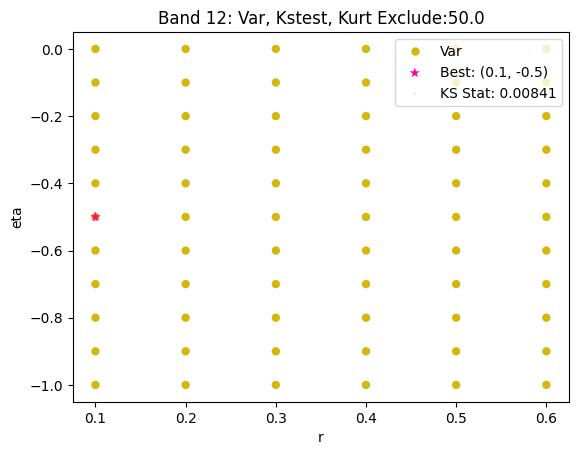

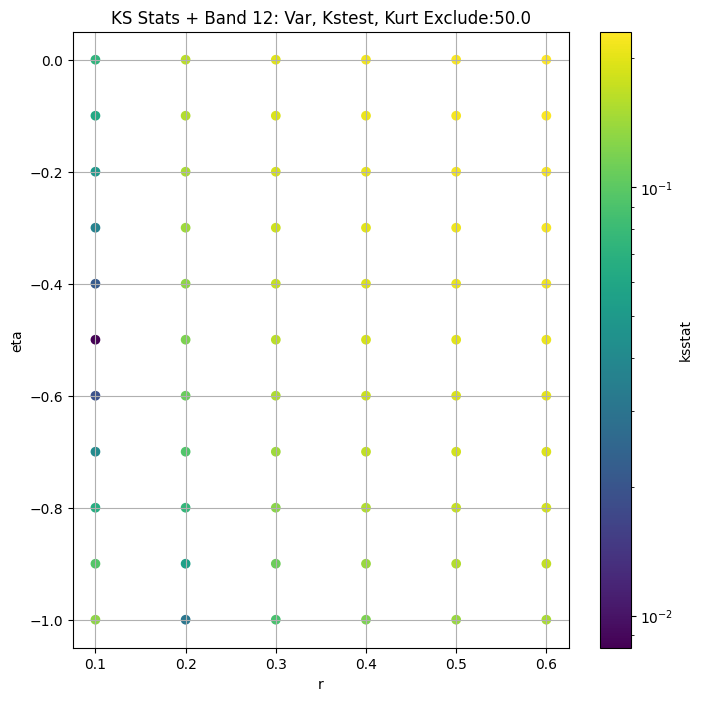

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0195734108642599 0.0006189628967442161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.012638724504695387 0.0005433994293961567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.01253900519383161 0.0005066729188843895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.014408349445609536 0.00047815783133034625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.014921058348566496 0.00045433812984978824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.009930056901541917 0.00041541624124569746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.00968599922526231 0.0003840551124703592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.012080803071989166 0.000357651039975643


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.010583624851575026 0.0003348731931205943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.011565240132334745 0.0003148967789180788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.013406618789046792 0.0002667314380980483
Number of samples: 100000, Without approximation : 100000.0


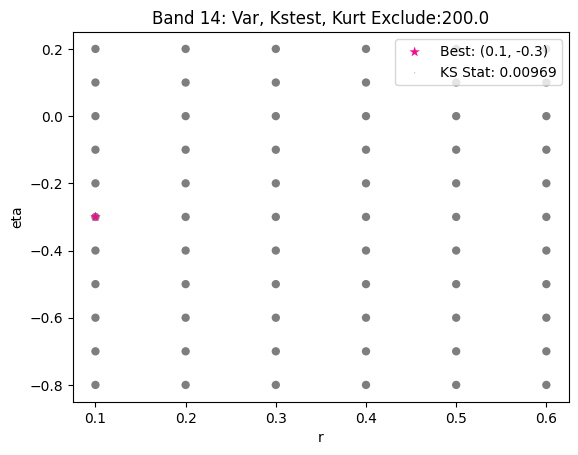

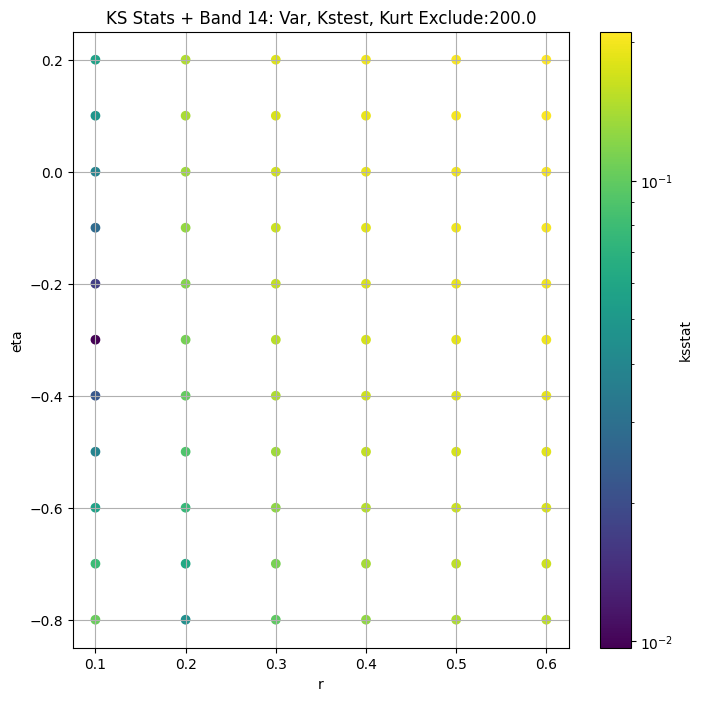

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.03555459398072336 0.00015652033820016855


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.028148518318133864 0.00011945049342745237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.03247954826625821 0.00010330364086578883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.02677914111685631 9.189927034690172e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.02190730062044699 8.304921787195934e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.026399654718685273 6.984362758194032e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.020240121679183765 6.0226579674918305e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.019565528006884103 5.2790929627225996e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.020359202433056667 4.682637421807467e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.014460032147050494 4.193646813123516e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.010922585209202251 3.145218661857404e-05
Number of samples: 100000, Without approximation : 100000.0


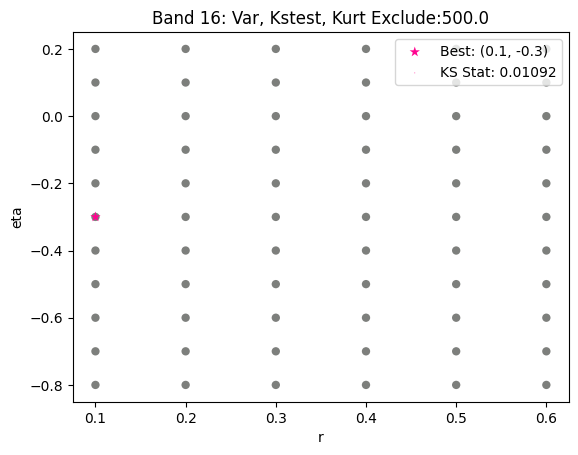

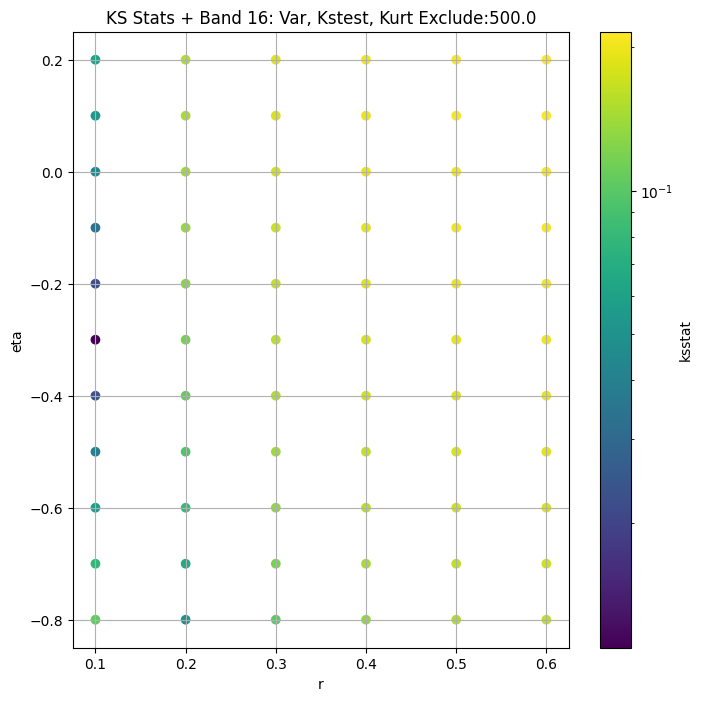

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013248   0.011009   0.016009   50.686798   24.662481   80.691333   
3     0.217878   0.182872   0.256856   41.428048   32.659045   52.120117   
5     2.125072   1.956127   2.298965    7.871349    6.856903    8.984187   
6     1.606098   1.478197   1.737453    7.848421    6.962206    8.786270   
8     0.153044   0.133159   0.176189   27.853211   17.169534   43.255178   
9     0.036976   0.032702   0.042352   22.968292   11.510382   58.350382   
11    0.023980   0.020239   0.028227   38.853401   27.311376   60.455321   
12    0.010856   0.008917   0.013248   56.908062   35.399686  112.468374   
14    0.000619   0.000499   0.000804   83.300207   35.923712  272.975980   
16    0.000157   0.000108   0.000229  217.463133   92.127912  521.275303   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.002289        0.4         -0.8   
3          100000.0             0.015478        0.1         -0.5   
5          100000.0             0.010411        0.7         -1.2   
6          100000.0             0.011242        0.6         -1.2   
8          100000.0             0.003845        0.3         -0.9   
9          100000.0             0.003150        0.6         -1.1   
11         100000.0             0.008697        0.2         -1.0   
12         100000.0             0.008415        0.1         -0.5   
14         100000.0             0.009686        0.1         -0.3   
16         100000.0             0.010923        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.024735e-03                   150.0            0.009238   
3      3.771164e-13                   300.0            0.126417   
5      4.307018e+00                   100.0            1.974448   
6      2.630169e+00                     0.0            1.606098   
8      3.813814e-03                     0.0            0.153044   
9      3.773165e-02                    50.0            0.033176   
11     1.563743e-05                    25.0            0.022012   
12     2.703653e-14                    50.0            0.009063   
14     3.000581e-16                   200.0            0.000384   
16     2.457325e-17                   500.0            0.000031   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
3                    0.004293  
5                    0.004293  
6                    0.004293  
8                    0.004293  
9                    0.004293  
11                   0.004293  
12                   0.004293  
14                   0.004293  
16                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.0037572392124974093, var: 0.00838778954932304


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.0034110987751896846, var: 0.008567942701632355


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.0029605842550132523, var: 0.00876629713802712


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.0026801055265944784, var: 0.008987527517300975


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.0022888099429409304, var: 0.009237692443100963


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.0019050454701994438, var: 0.009528908768153129


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.0015753936027622425, var: 0.009878767925443318


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.0018127064363669954, var: 0.010314777838478348


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.0019189073178778049, var: 0.01088155901400891
Number of samples: 100000, Without approximation : 100000.0


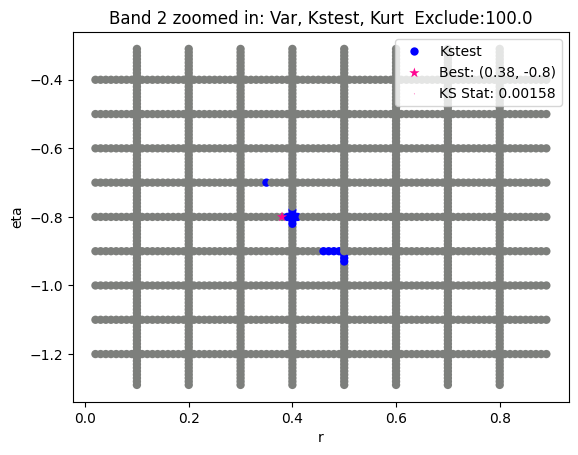

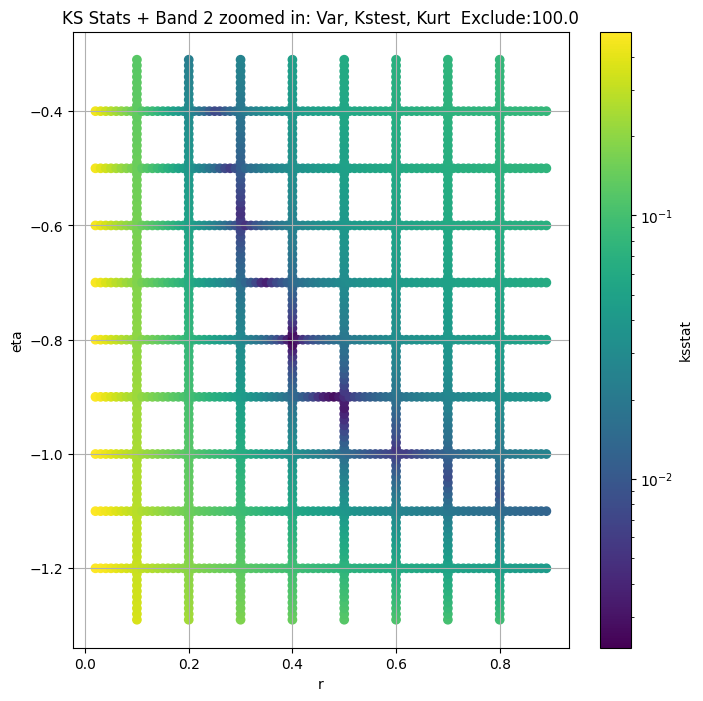

Band 3


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 100 = 400, ksstat: 0.015554162851806996, var: 0.11233134949586288


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 75 = 375, ksstat: 0.015947291978032168, var: 0.11554576527958342


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 50 = 350, ksstat: 0.015790781153091737, var: 0.11895921358489049


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 25 = 325, ksstat: 0.015397577340293088, var: 0.1225729853846742


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 0 = 300, ksstat: 0.01494844349471135, var: 0.1264174387709751


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -25 = 275, ksstat: 0.014788378307693417, var: 0.13053770243773583


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -50 = 250, ksstat: 0.01467575371884483, var: 0.13497104744500588


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -75 = 225, ksstat: 0.014408236241772676, var: 0.13978119805918124


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -100 = 200, ksstat: 0.014108189615110261, var: 0.1450362056142682
Number of samples: 100000, Without approximation : 100000.0


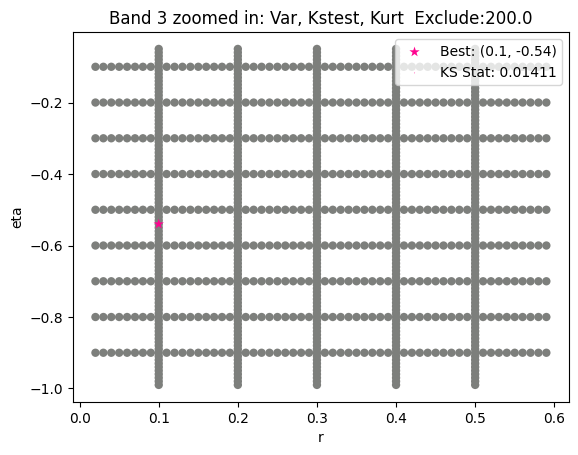

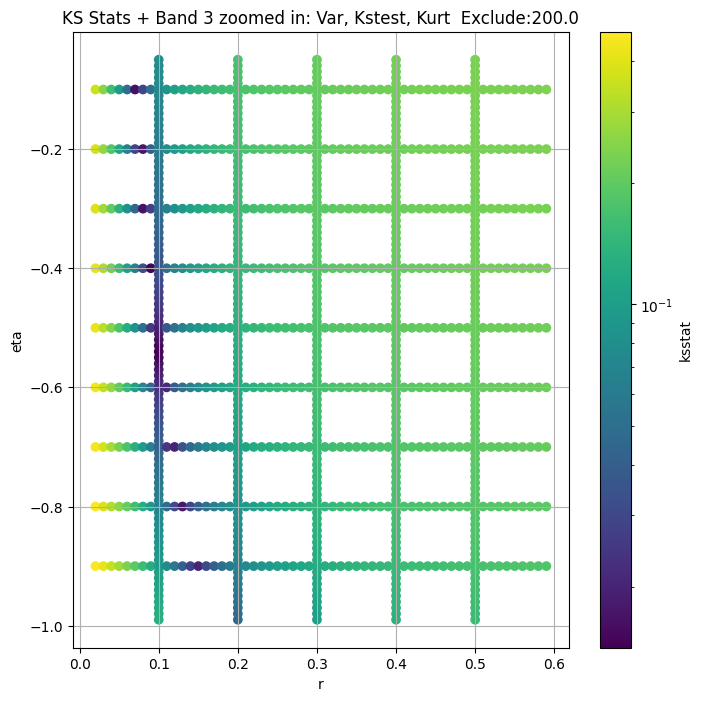

Band 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.01056780307070826, var: 1.8663530544086877


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.011151330805548754, var: 1.8913263420514337


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.011028692548304755, var: 1.9175253624847275


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.010728115391919715, var: 1.9451485711271363


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.010411111389656946, var: 1.9744475548235993


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.01007067779270561, var: 2.005827354823554


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.009858405091488387, var: 2.039922340806598


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.009705683116185207, var: 2.077960425165075


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.009129496448979382, var: 2.1250723130795306
Number of samples: 100000, Without approximation : 100000.0


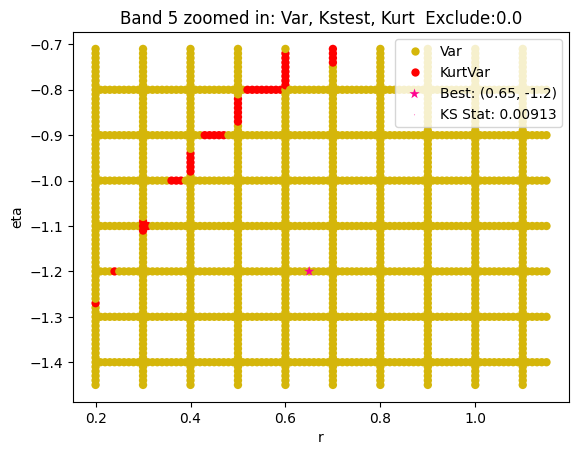

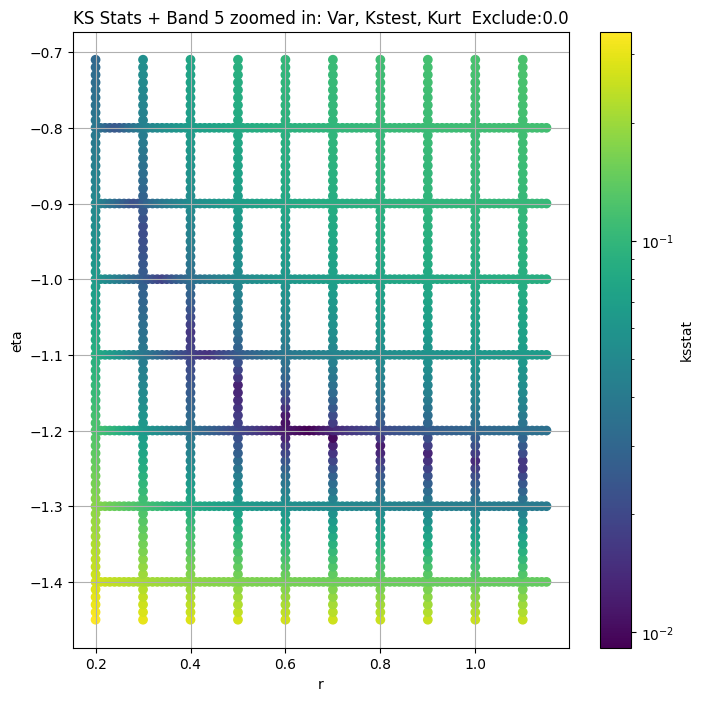

Band 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 100 = 100, ksstat: 0.01098811401588462, var: 1.4981864128365805


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 75 = 75, ksstat: 0.011153229063976644, var: 1.5215001538243327


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 50 = 50, ksstat: 0.010953313517543528, var: 1.5465964575812383


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 25 = 25, ksstat: 0.01110536253663047, var: 1.5741116977454819


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 0 = 0, ksstat: 0.011241847951715844, var: 1.6060981823861697
Number of samples: 100000, Without approximation : 100000.0


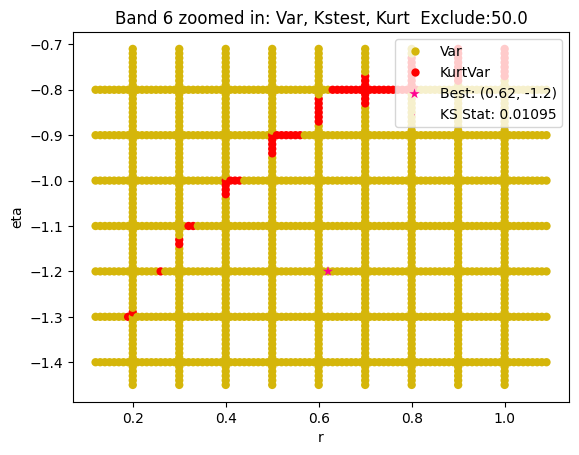

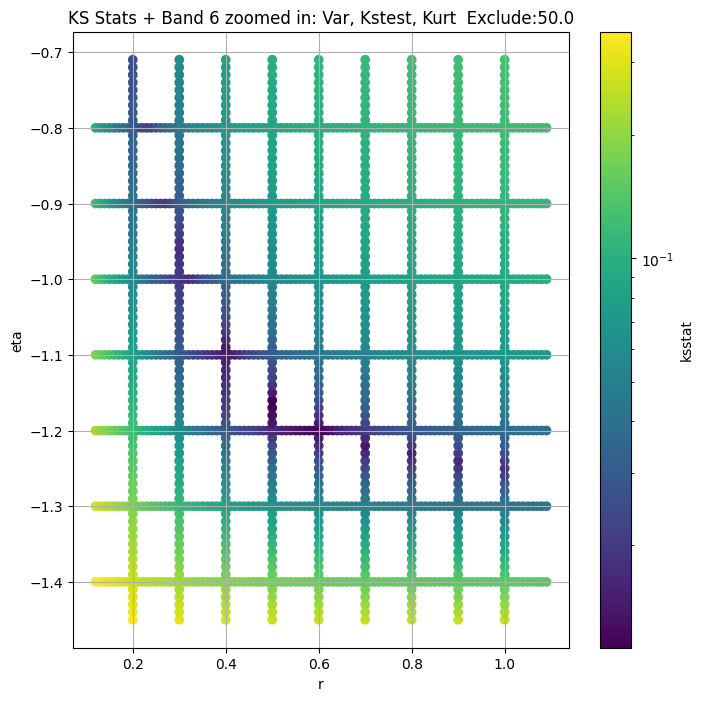

Band 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.0036418410411065416, var: 0.12541395127888666


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.003979680846395994, var: 0.12964128983679696


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.00301691276973072, var: 0.13475030997096363


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.00194345123537909, var: 0.14136788759246646


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.002355551476492357, var: 0.1530443556291902
Number of samples: 100000, Without approximation : 100000.0


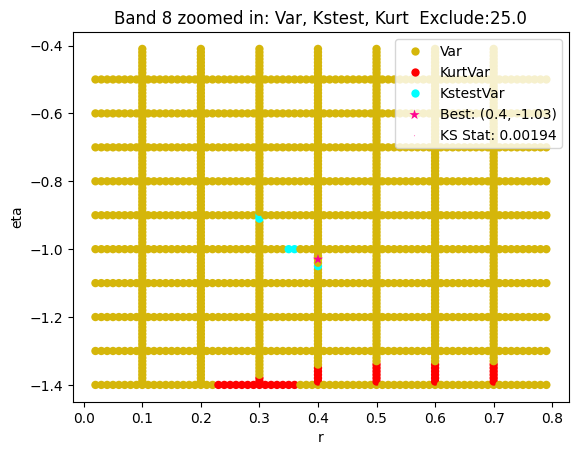

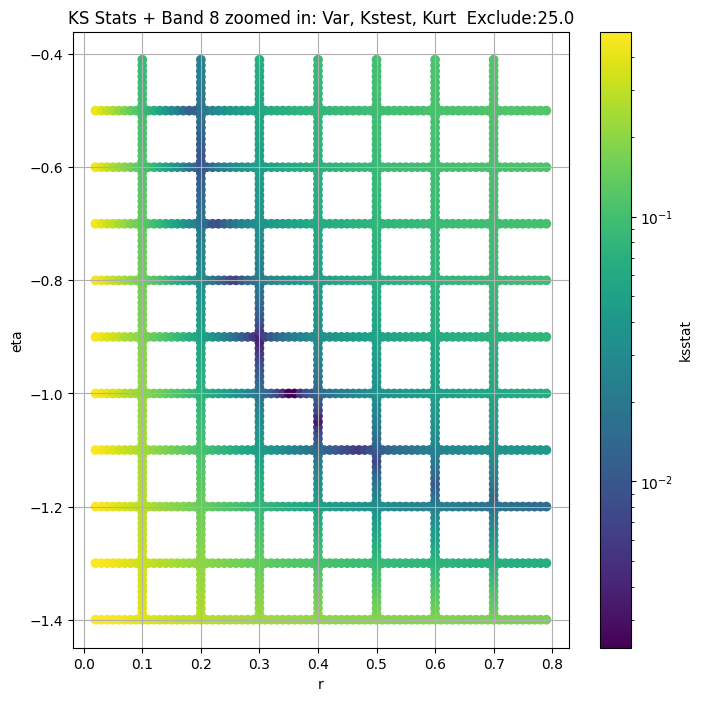

Band 9


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 100 = 150, ksstat: 0.0042639256993382, var: 0.030133390737745826


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 75 = 125, ksstat: 0.0038681331262304594, var: 0.03074579932914457


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 50 = 100, ksstat: 0.003263334400469685, var: 0.03143290924140905


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 25 = 75, ksstat: 0.003149336375002143, var: 0.032224869074275804


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 0 = 50, ksstat: 0.0031499856808854254, var: 0.03317642299092878


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -25 = 25, ksstat: 0.002553606840756756, var: 0.034425149781486


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -50 = 0, ksstat: 0.0027122500973153496, var: 0.03697601450676882
Number of samples: 100000, Without approximation : 100000.0


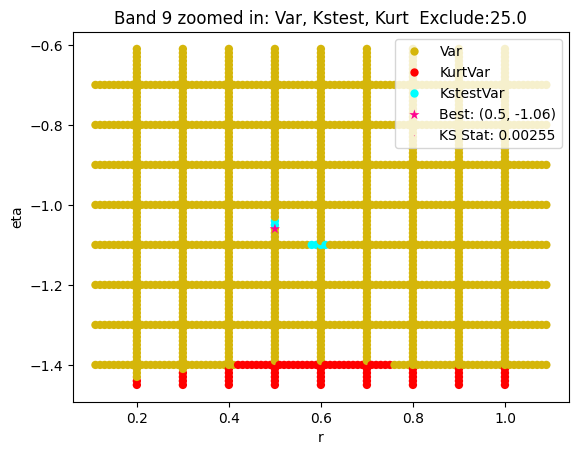

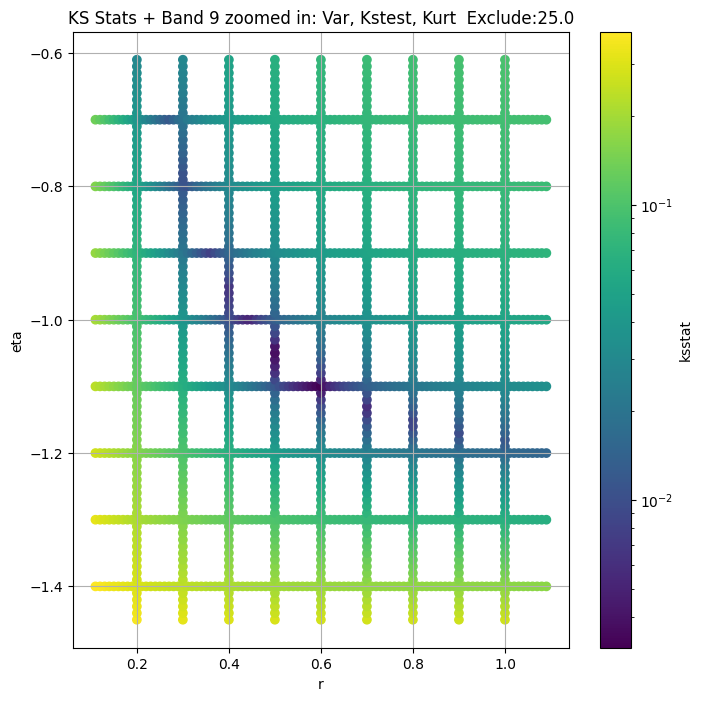

Band 11


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.007590573305238851, var: 0.018298652716457163


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.007645543341578076, var: 0.019020752609091956


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.007316691623317384, var: 0.01984249196872149


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.007250404524562361, var: 0.02080757687804678


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.00606299546274509, var: 0.022012122562690677


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.006909825296349037, var: 0.023979804084388177
Number of samples: 100000, Without approximation : 100000.0


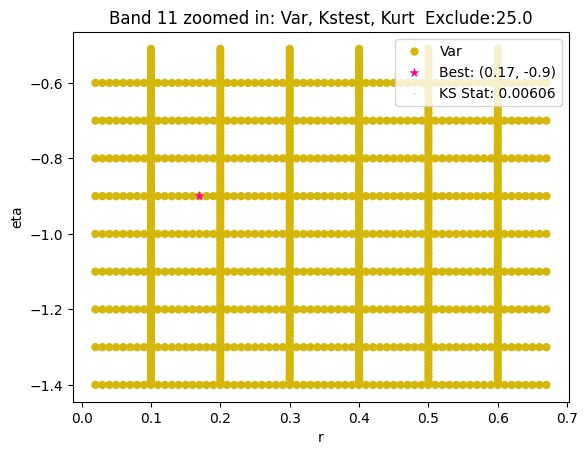

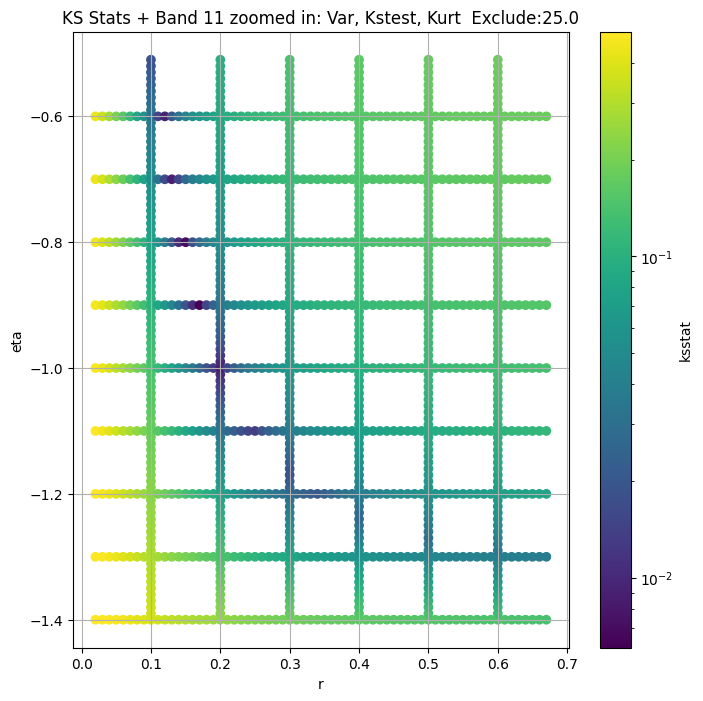

Band 12


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 100 = 150, ksstat: 0.00952313449423936, var: 0.00744579971025966


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 75 = 125, ksstat: 0.008635940371456208, var: 0.007771243308441993


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 50 = 100, ksstat: 0.00929872206554742, var: 0.008138208714098046


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 25 = 75, ksstat: 0.008726171196181423, var: 0.00856017818153234


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 0 = 50, ksstat: 0.008133353060900517, var: 0.009063220581702504


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -25 = 25, ksstat: 0.007697560281084821, var: 0.009706071639328654


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -50 = 0, ksstat: 0.007799738914079535, var: 0.010855534648658354
Number of samples: 100000, Without approximation : 100000.0


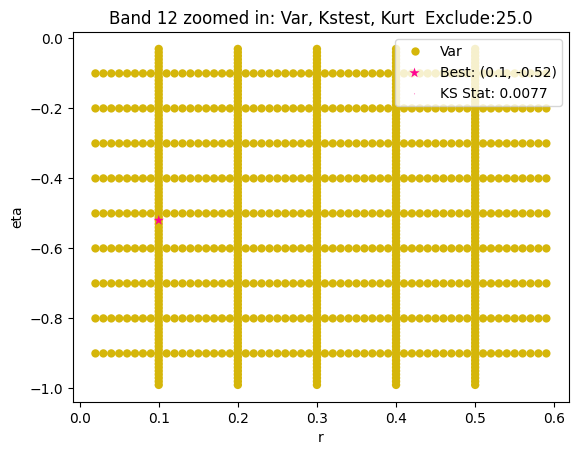

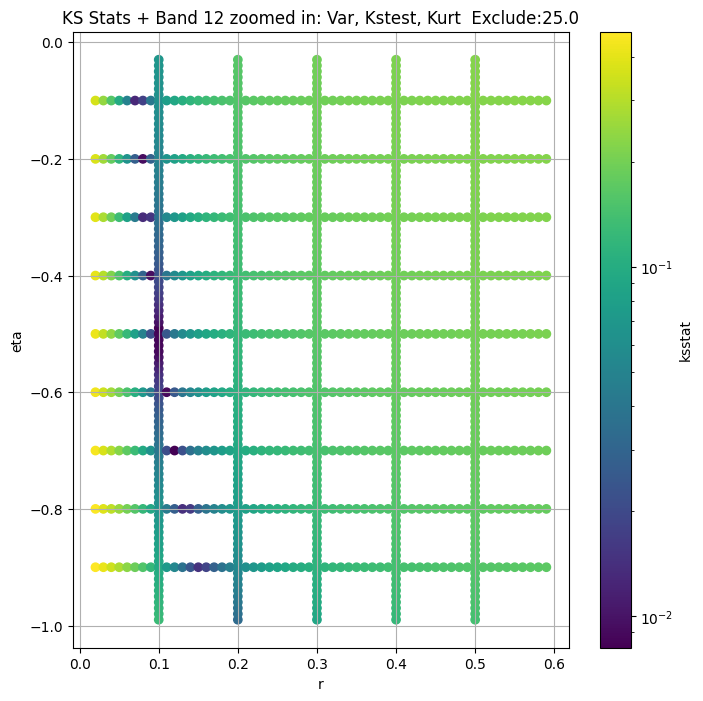

Band 14


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.01049589636600277, var: 0.0003348731931205943


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.010178914013498248, var: 0.00034586870521731704


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.009850854202072684, var: 0.000357651039975643


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.009108794439271595, var: 0.0003703337687799872


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.009150430594627015, var: 0.0003840551124703592


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.008831607766680794, var: 0.00039899383728038526


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.00878040080203879, var: 0.00041541624124569746


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.008795510427900378, var: 0.0004336974791607205


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.008512622782263057, var: 0.00045433812984978824
Number of samples: 100000, Without approximation : 100000.0


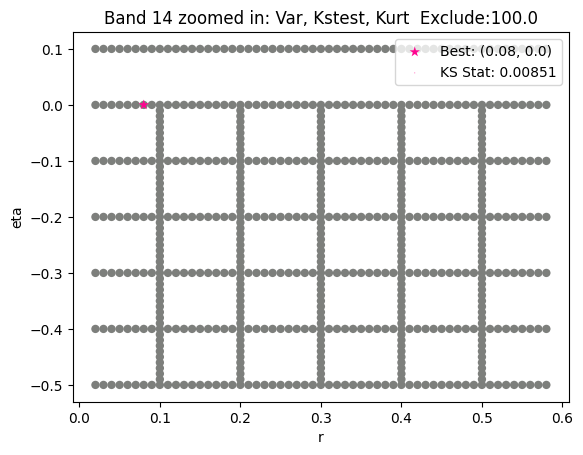

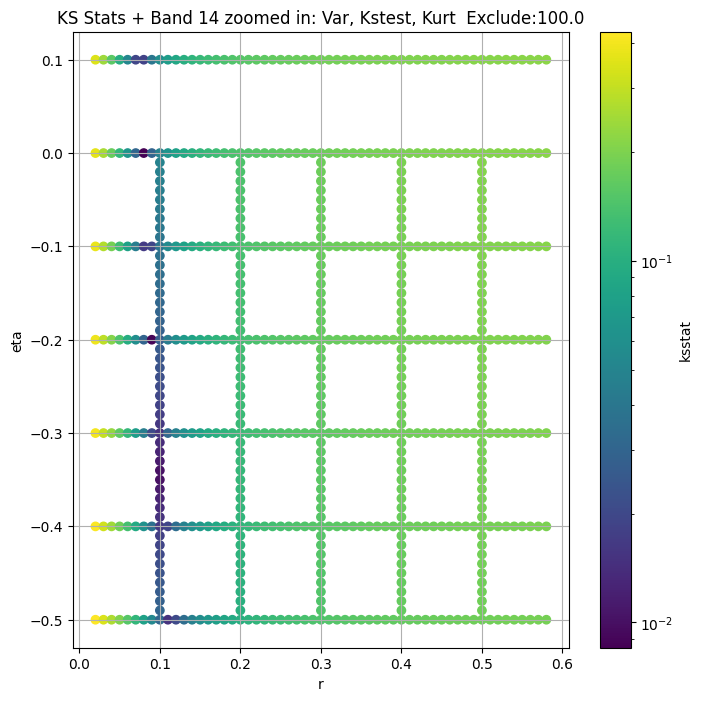

Band 16


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.010432255463239547, var: 2.66548923259763e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.010108649294843784, var: 2.7735948919063018e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.00993708200431398, var: 2.8890261088923586e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.010686689498329405, var: 3.0126252088468948e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.010922585209202251, var: 3.145218661857404e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.011711138102240781, var: 3.287548975670428e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.010458372379698766, var: 3.440890985224241e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.011683630871537676, var: 3.606440580190948e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.013034325794902879, var: 3.7858258855614544e-05
Number of samples: 100000, Without approximation : 100000.0


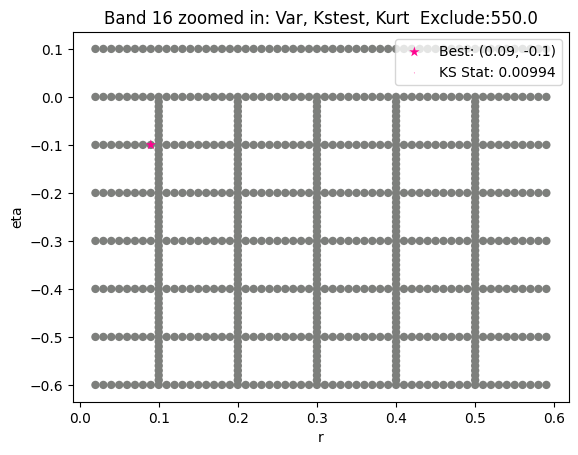

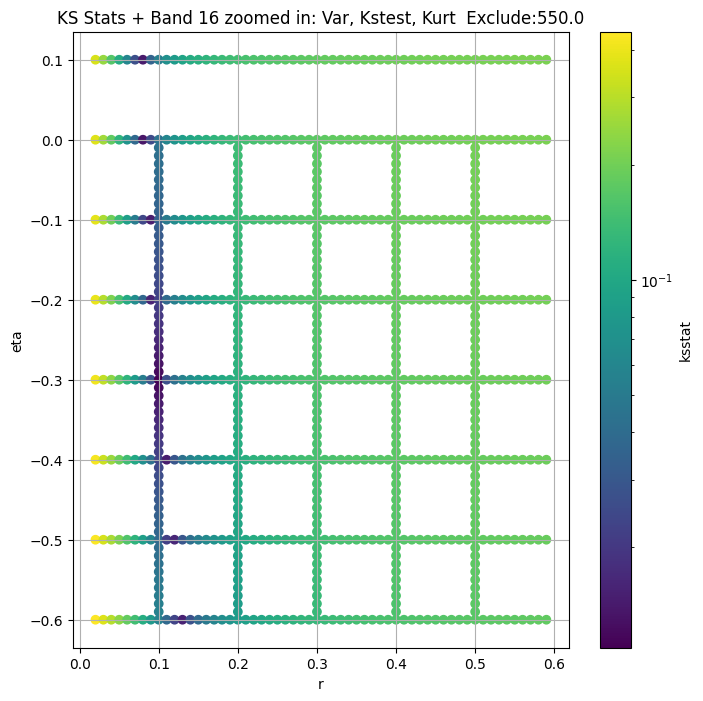

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013248   0.011009   0.016009   50.686798   24.662481   80.691333   
3     0.217878   0.182872   0.256856   41.428048   32.659045   52.120117   
5     2.125072   1.956127   2.298965    7.871349    6.856903    8.984187   
6     1.606098   1.478197   1.737453    7.848421    6.962206    8.786270   
8     0.153044   0.133159   0.176189   27.853211   17.169534   43.255178   
9     0.036976   0.032702   0.042352   22.968292   11.510382   58.350382   
11    0.023980   0.020239   0.028227   38.853401   27.311376   60.455321   
12    0.010856   0.008917   0.013248   56.908062   35.399686  112.468374   
14    0.000619   0.000499   0.000804   83.300207   35.923712  272.975980   
16    0.000157   0.000108   0.000229  217.463133   92.127912  521.275303   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.002289        0.4         -0.8   
3          100000.0             0.015478        0.1         -0.5   
5          100000.0             0.010411        0.7         -1.2   
6          100000.0             0.011242        0.6         -1.2   
8          100000.0             0.003845        0.3         -0.9   
9          100000.0             0.003150        0.6         -1.1   
11         100000.0             0.008697        0.2         -1.0   
12         100000.0             0.008415        0.1         -0.5   
14         100000.0             0.009686        0.1         -0.3   
16         100000.0             0.010923        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.024735e-03                   150.0            0.009879   
3      3.771164e-13                   300.0            0.145036   
5      4.307018e+00                   100.0            2.125072   
6      2.630169e+00                     0.0            1.546596   
8      3.813814e-03                     0.0            0.141368   
9      3.773165e-02                    50.0            0.034425   
11     1.563743e-05                    25.0            0.022012   
12     2.703653e-14                    50.0            0.009706   
14     3.000581e-16                   200.0            0.000454   
16     2.457325e-17                   500.0            0.000029   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.001575    0.38     -0.80   
3                    0.004293          0.014108    0.10     -0.54   
5                    0.004293          0.009129    0.65     -1.20   
6                    0.004293          0.010953    0.62     -1.20   
8                    0.004293          0.001943    0.40     -1.03   
9                    0.004293          0.002554    0.50     -1.06   
11                   0.004293          0.006063    0.17     -0.90   
12                   0.004293          0.007698    0.10     -0.52   
14                   0.004293          0.008513    0.08      0.00   
16                   0.004293          0.009937    0.09     -0.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     8.308357e-04                100.0       759375  
3     5.793230e-13                200.0         9375  
5     4.077603e+00                  0.0        21093  
6     2.709786e+00                 50.0        15819  
8     3.228578e-02                 25.0       506250  
9     2.080824e-02                 25.0       284764  
11    7.687892e-07                 25.0        50000  
12    3.346699e-14                 25.0        31639  
14    2.251475e-21                100.0        25000  
16    8.295931e-20                550.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

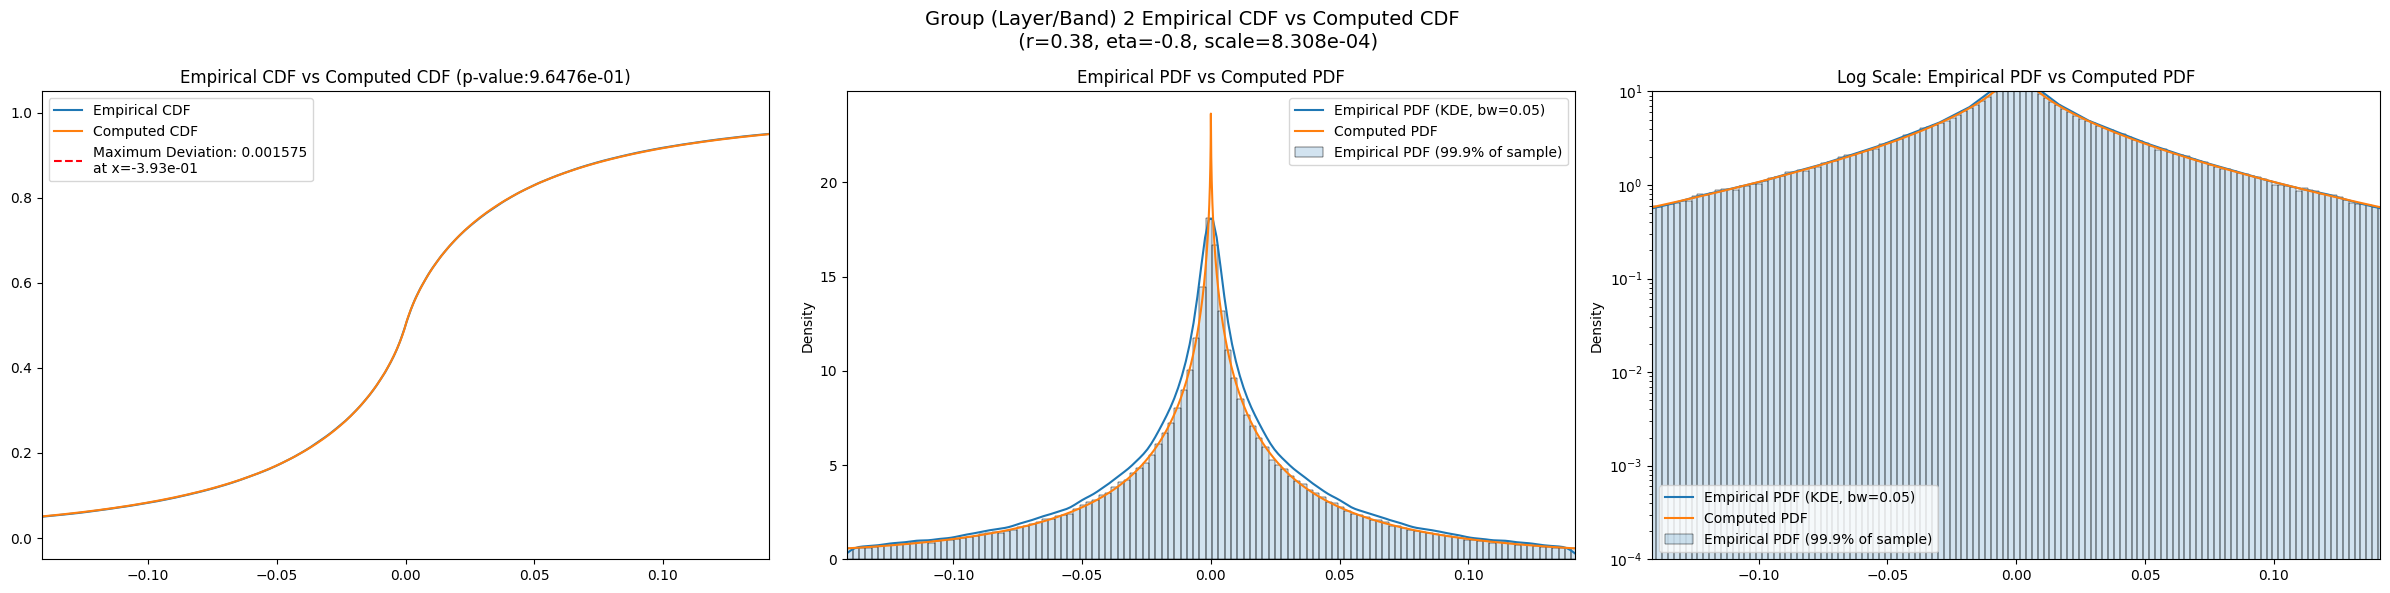

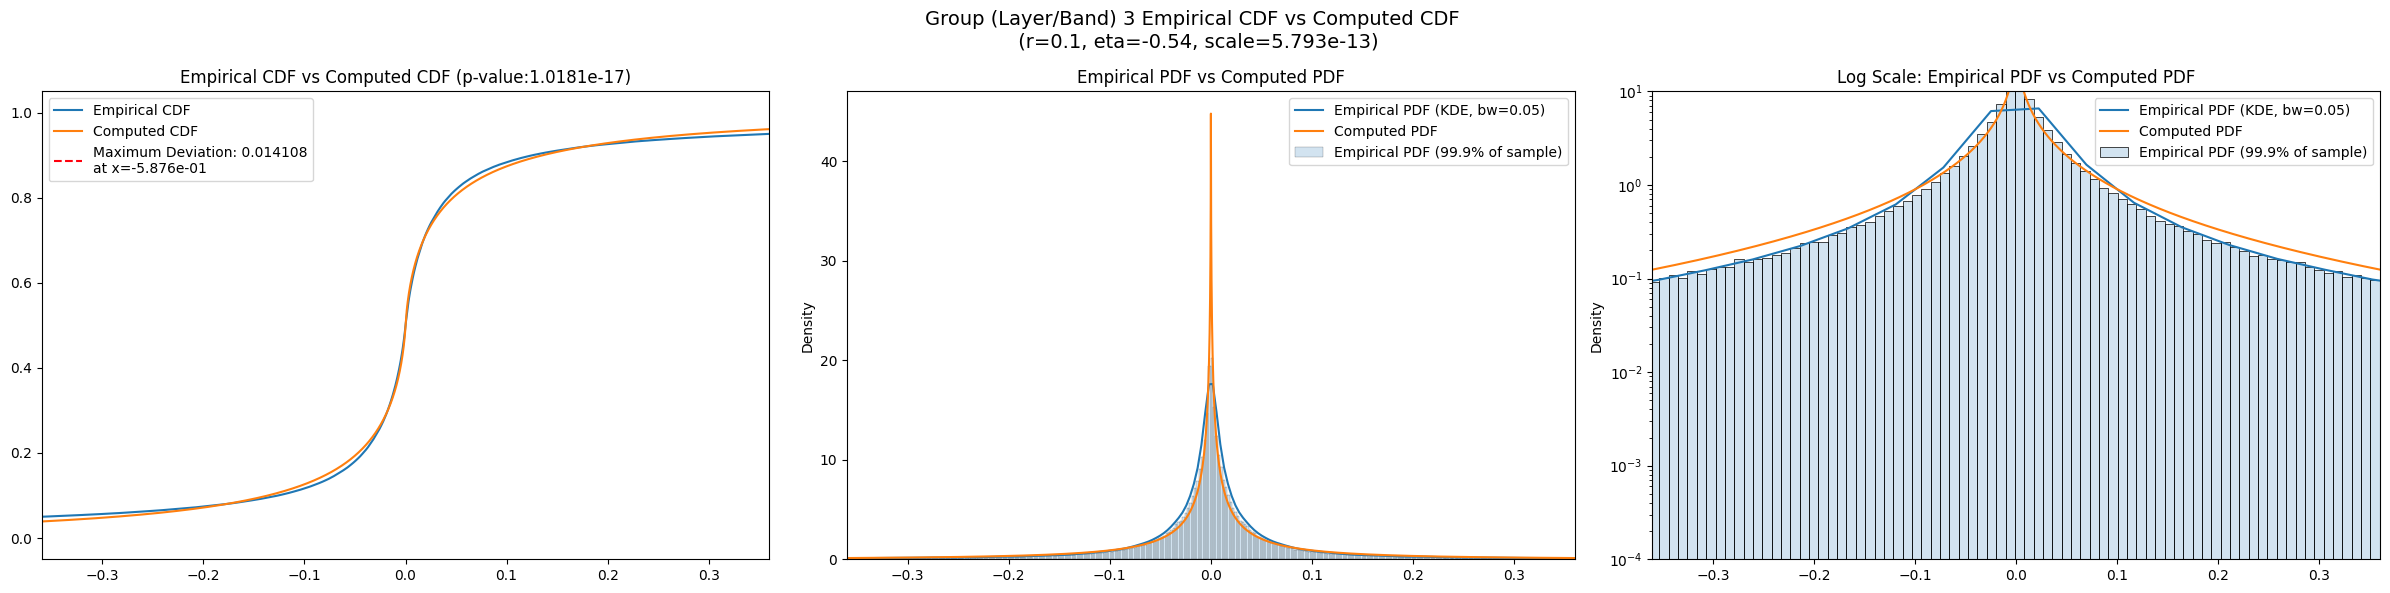

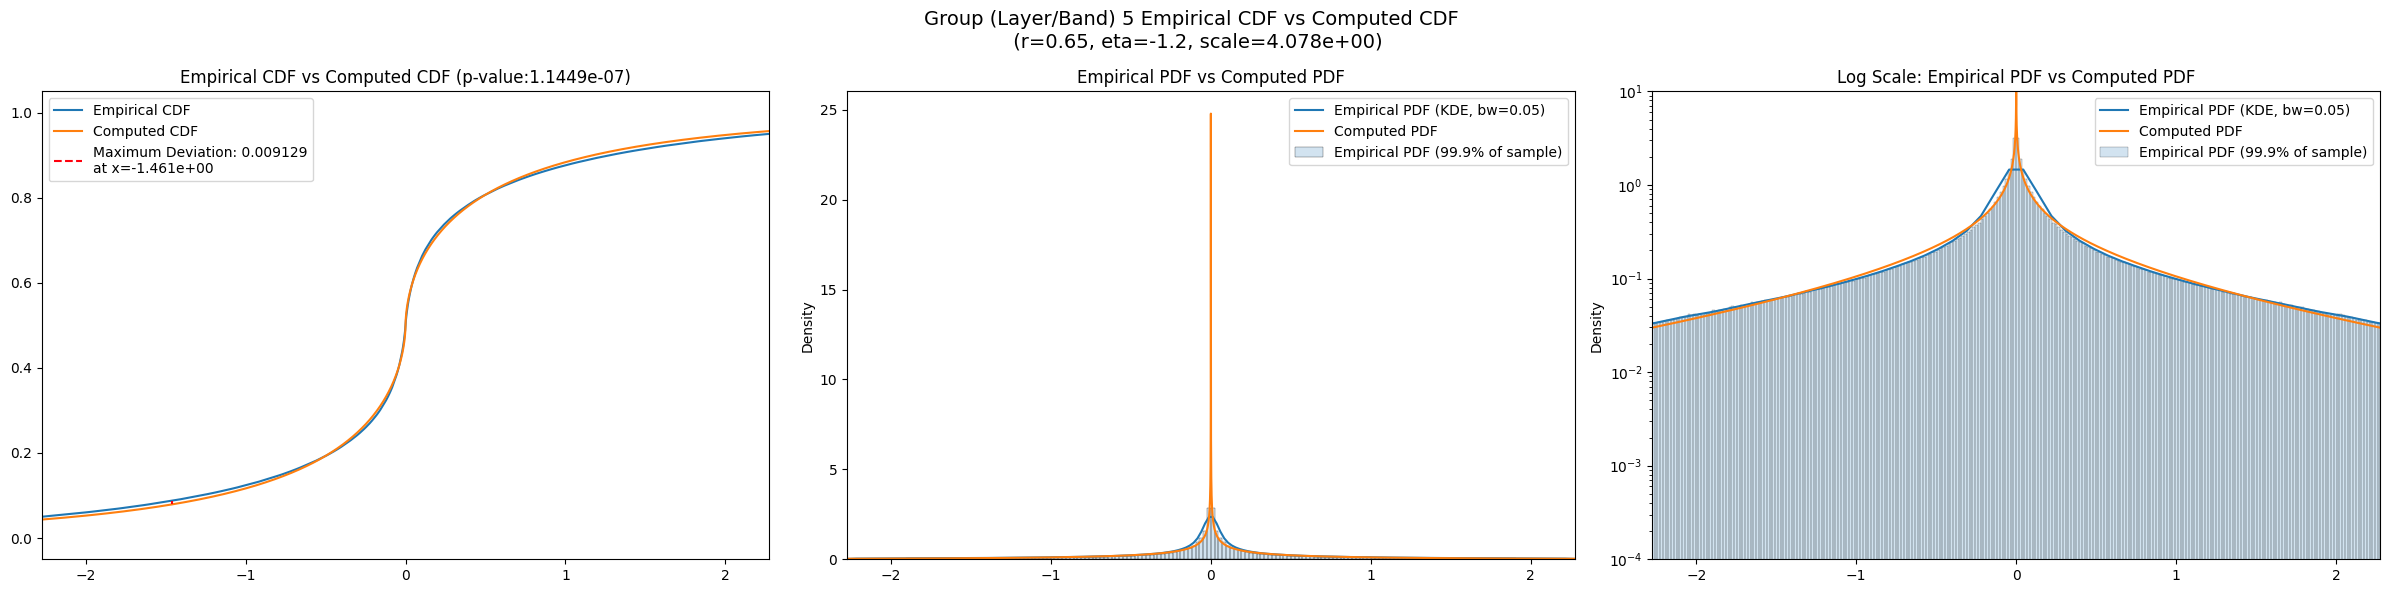

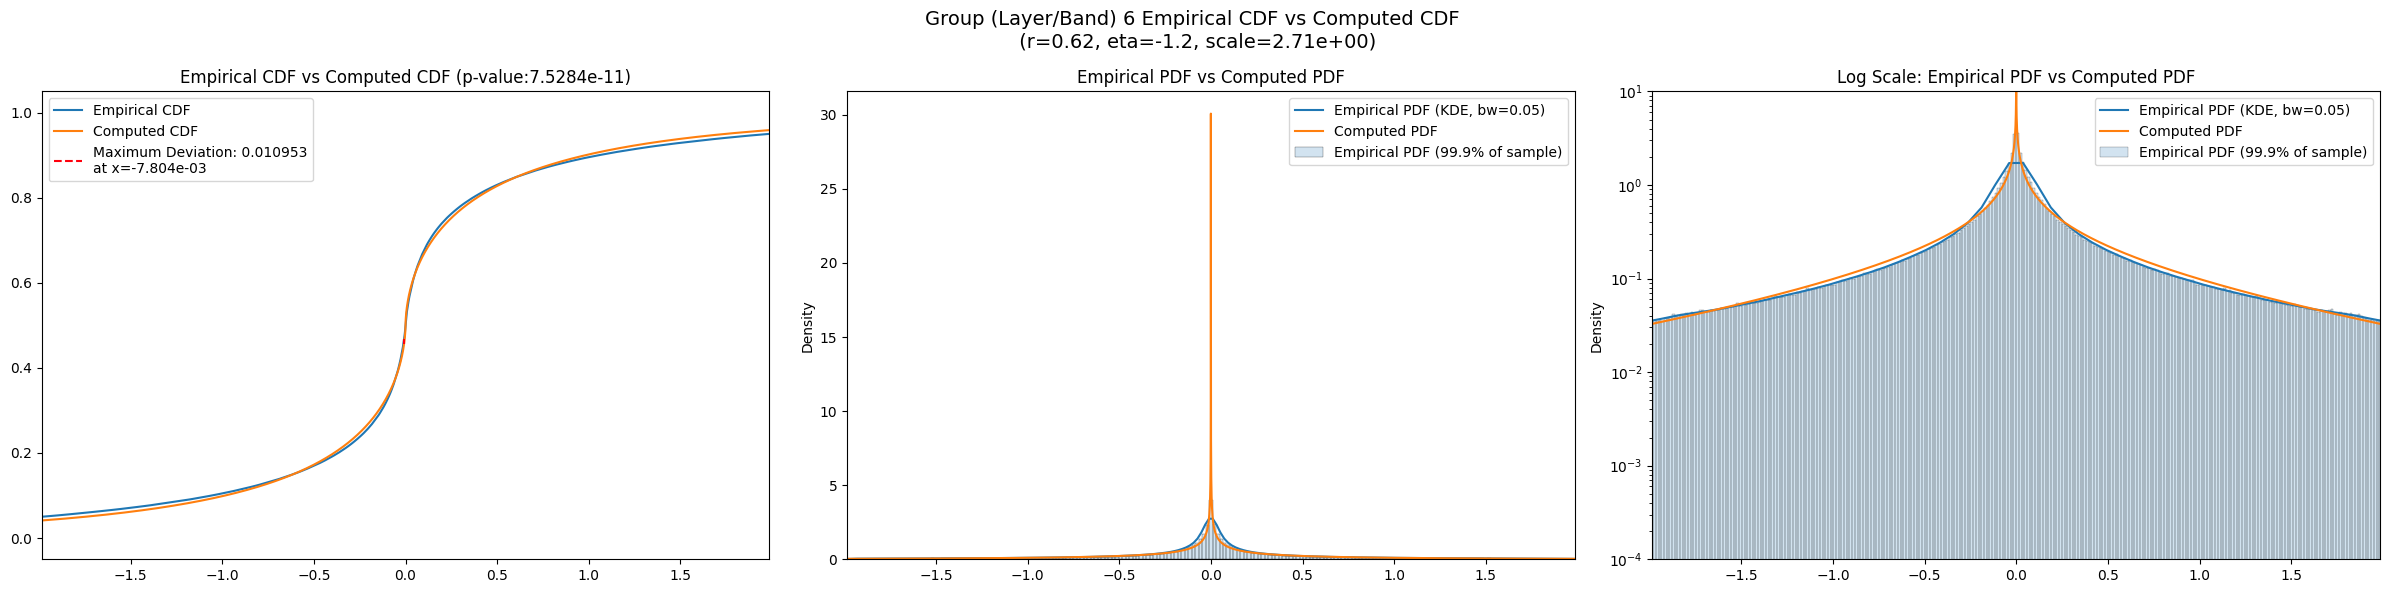

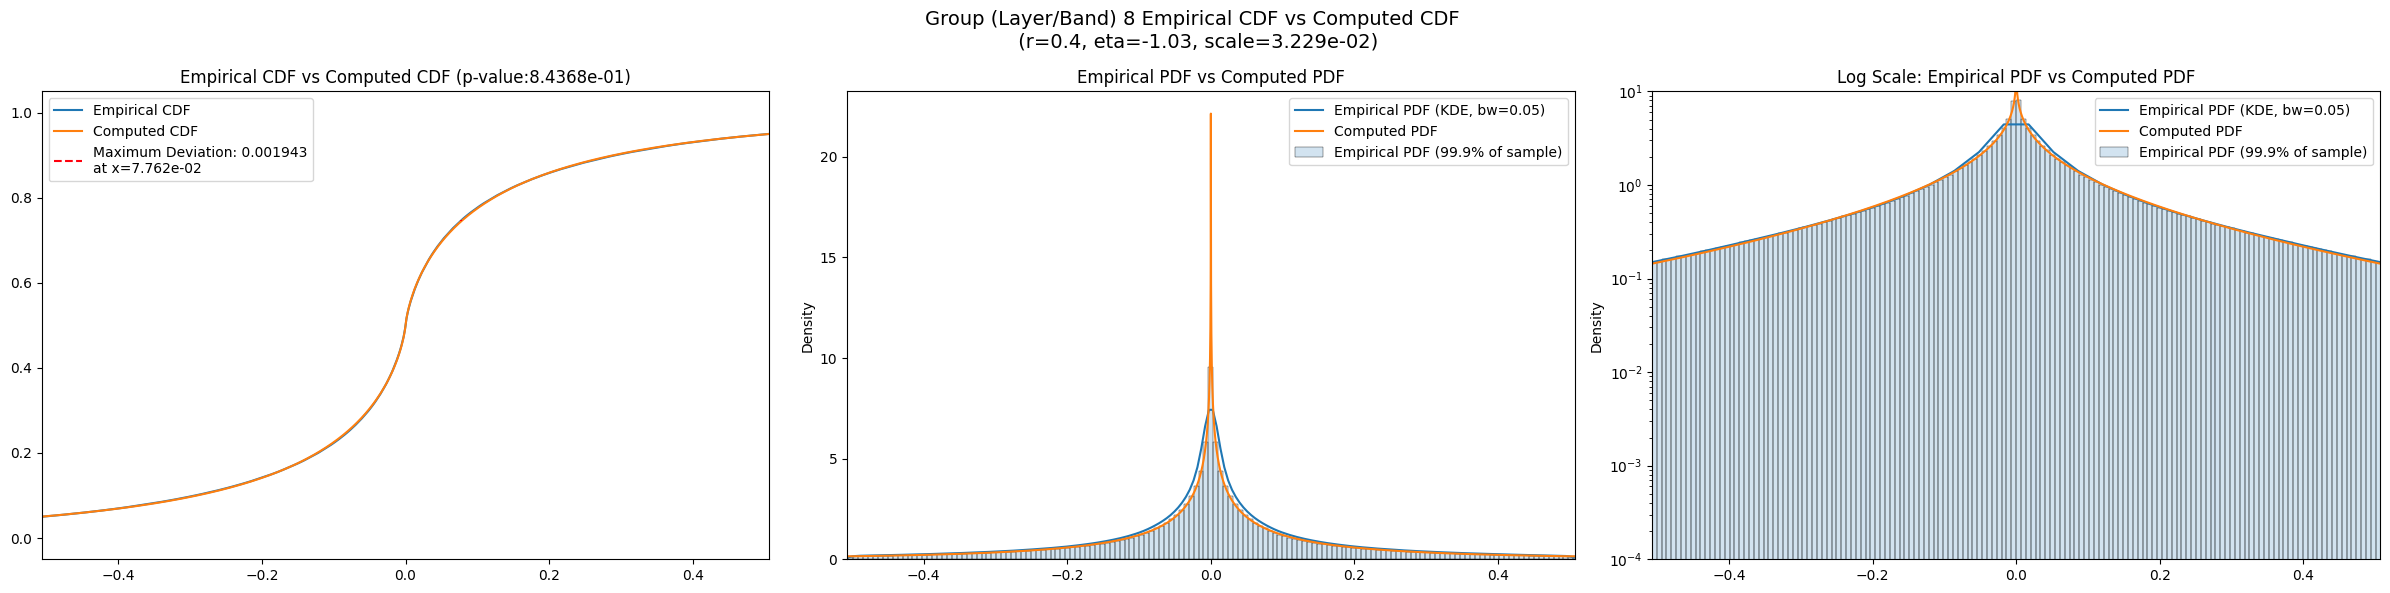

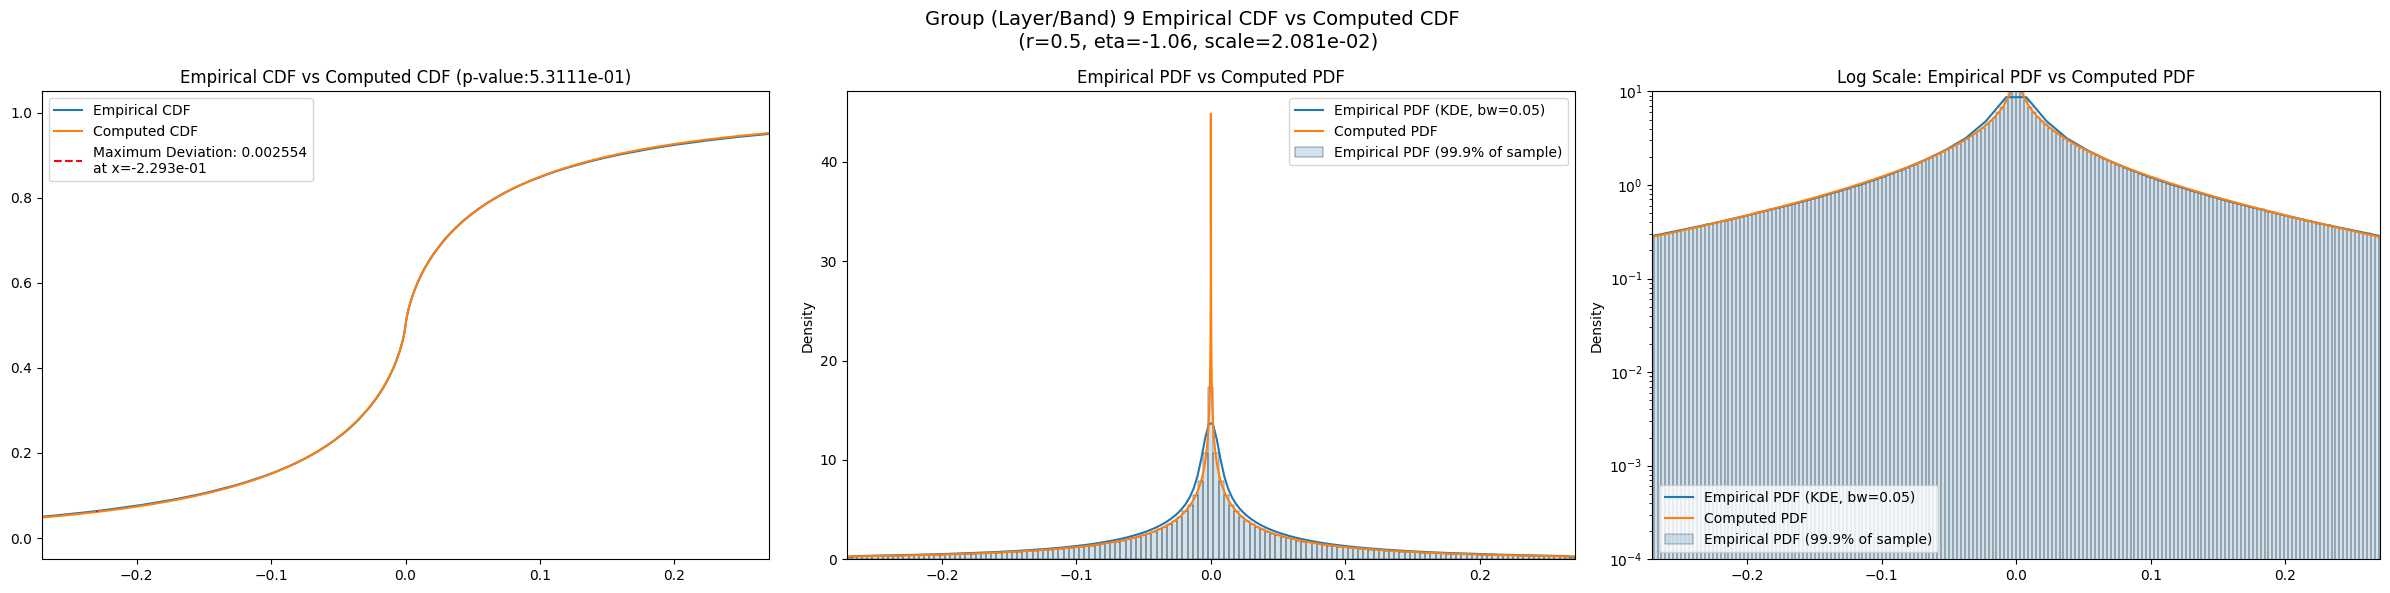

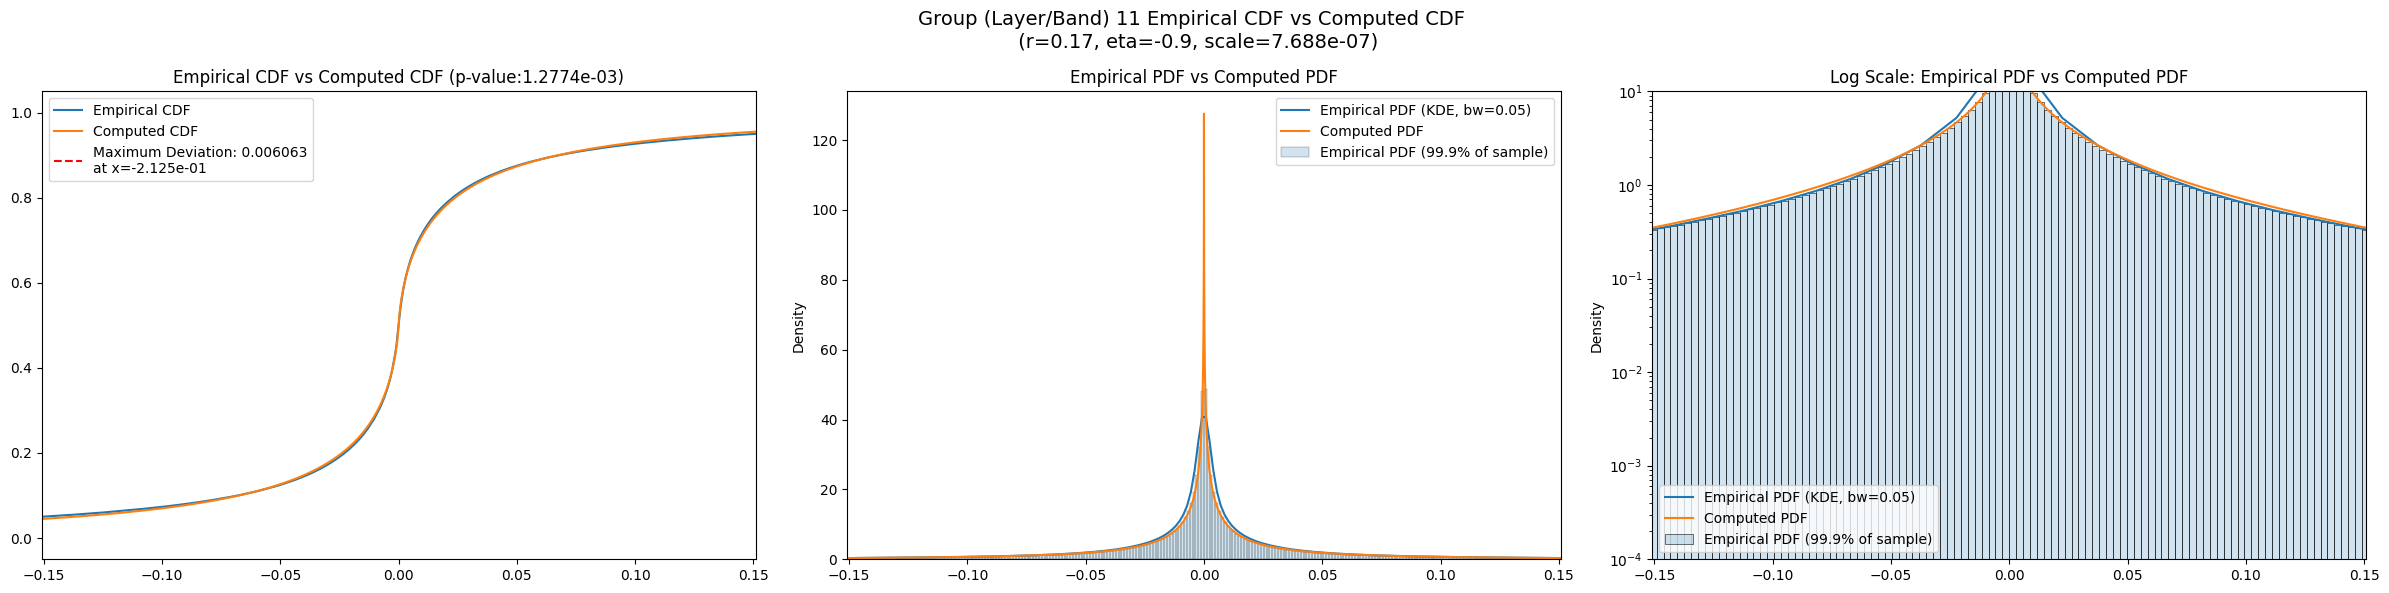

C:\Users\Henry\AppData\Local\Temp\ipykernel_48804\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


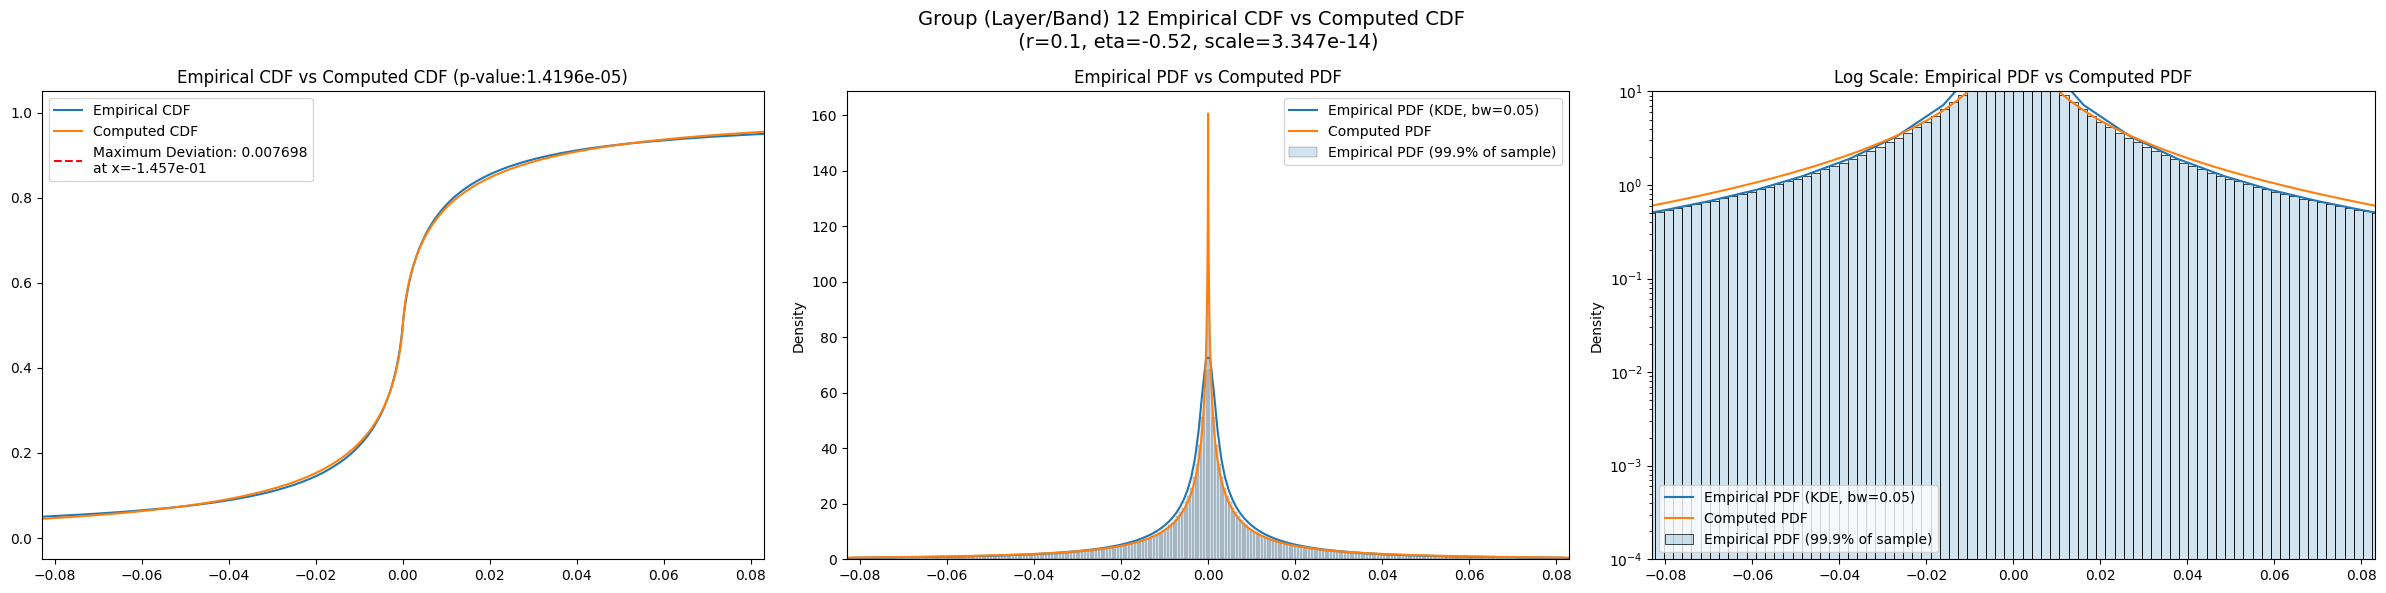

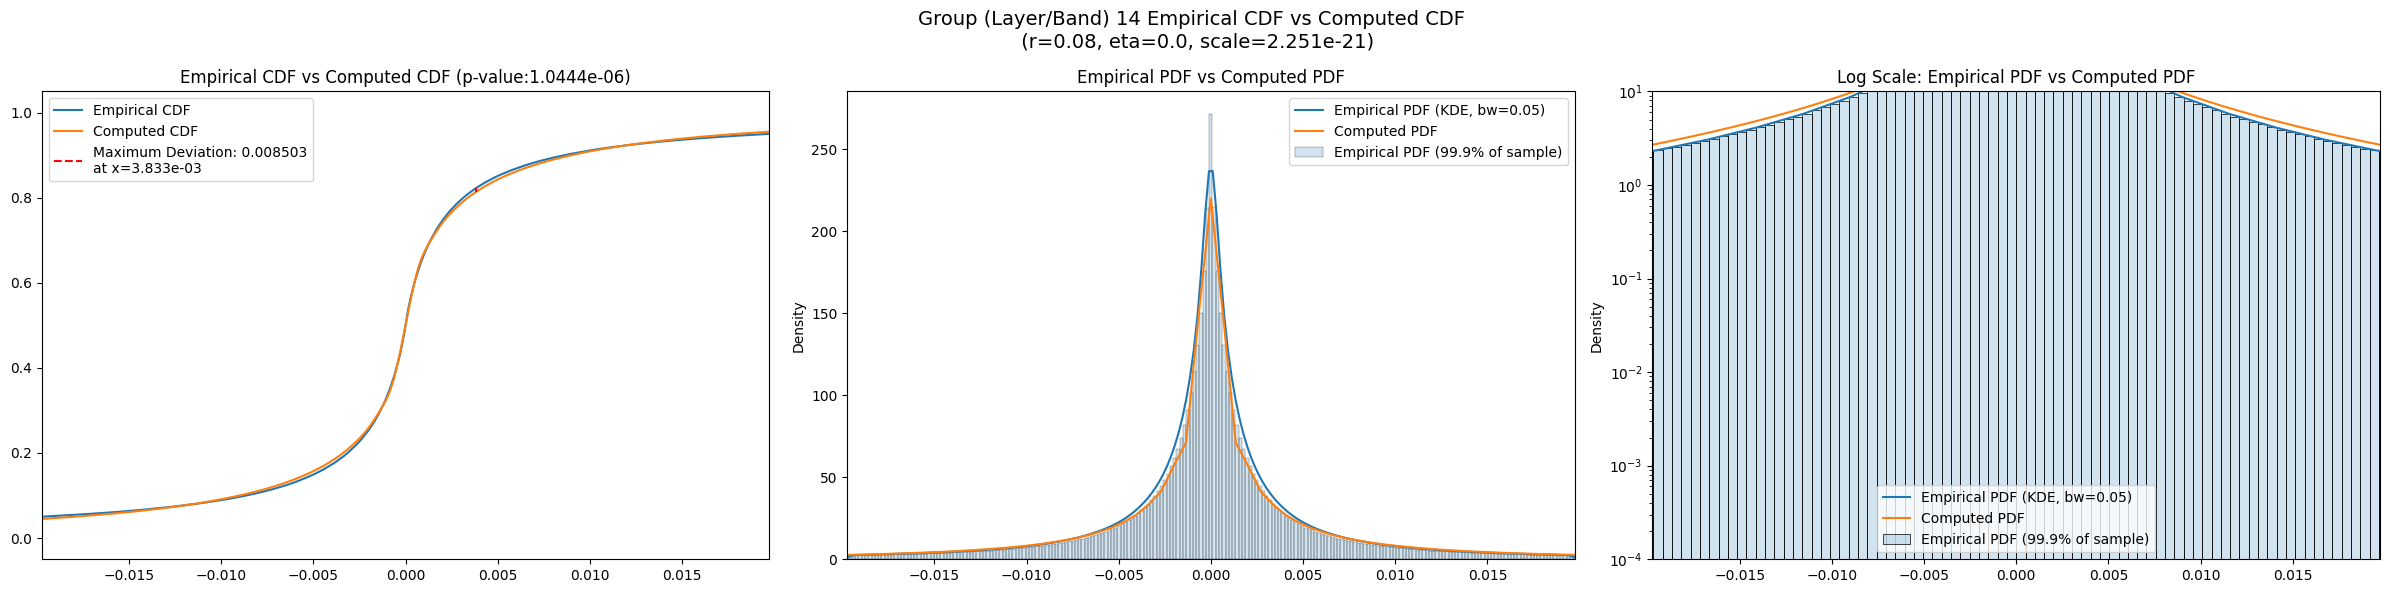

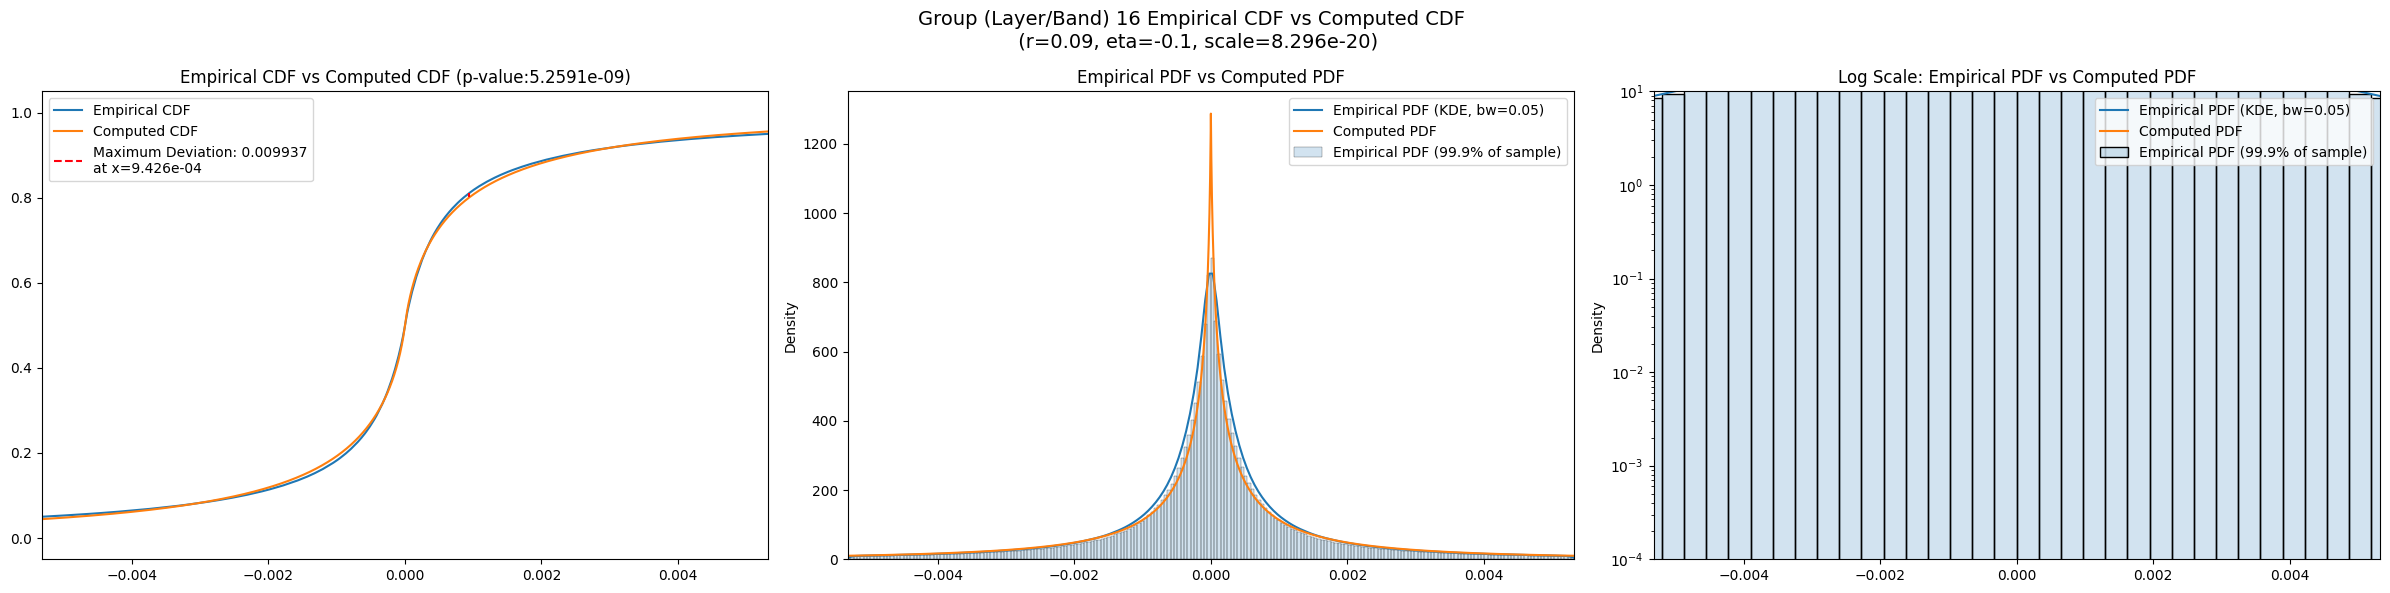

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013248   0.011009   0.016009   50.686798   24.662481   80.691333   
3     0.217878   0.182872   0.256856   41.428048   32.659045   52.120117   
5     2.125072   1.956127   2.298965    7.871349    6.856903    8.984187   
6     1.606098   1.478197   1.737453    7.848421    6.962206    8.786270   
8     0.153044   0.133159   0.176189   27.853211   17.169534   43.255178   
9     0.036976   0.032702   0.042352   22.968292   11.510382   58.350382   
11    0.023980   0.020239   0.028227   38.853401   27.311376   60.455321   
12    0.010856   0.008917   0.013248   56.908062   35.399686  112.468374   
14    0.000619   0.000499   0.000804   83.300207   35.923712  272.975980   
16    0.000157   0.000108   0.000229  217.463133   92.127912  521.275303   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2          100000.0             0.002289        0.4         -0.8  ...   
3          100000.0             0.015478        0.1         -0.5  ...   
5          100000.0             0.010411        0.7         -1.2  ...   
6          100000.0             0.011242        0.6         -1.2  ...   
8          100000.0             0.003845        0.3         -0.9  ...   
9          100000.0             0.003150        0.6         -1.1  ...   
11         100000.0             0.008697        0.2         -1.0  ...   
12         100000.0             0.008415        0.1         -0.5  ...   
14         100000.0             0.009686        0.1         -0.3  ...   
16         100000.0             0.010923        0.1         -0.3  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.051660              0.057078         1.280630e-283   
3           0.059942              0.084116          0.000000e+00   
5           0.561633              0.090352          0.000000e+00   
6           0.462174              0.089943          0.000000e+00   
8           0.154512              0.072247          0.000000e+00   
9           0.084493              0.070258          0.000000e+00   
11          0.029725              0.089447          0.000000e+00   
12          0.015750              0.085379          0.000000e+00   
14          0.004375              0.078357          0.000000e+00   
16          0.001208              0.077646          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.044853             0.030492         3.292890e-81  0.035427   
3          0.054494             0.061701         0.000000e+00  0.040751   
5          0.478992             0.065897         0.000000e+00  0.370918   
6          0.398981             0.065228         0.000000e+00  0.306429   
8          0.133254             0.046399        1.609920e-187  0.104302   
9          0.072509             0.044875        1.965530e-175  0.056754   
11         0.025982             0.065517         0.000000e+00  0.019608   
12         0.013963             0.061748         0.000000e+00  0.010480   
14         0.003916             0.054162        2.075060e-255  0.002970   
16         0.001082             0.053206        1.769970e-246  0.000826   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.032544   1.884320e-92          9.647650e-01  
3          0.056619  4.385390e-279          1.017972e-17  
5          0.067064   0.000000e+00          1.144930e-07  
6          0.065205   0.000000e+00          7.528372e-11  
8          0.047995  1.265160e-200          8.436805e-01  
9          0.046804  8.333120e-191          5.311058e-01  
11         0.063972   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.002289                 0.004293          0.001575   
3                0.015478                 0.004293          0.014108   
5                0.010411                 0.004293          0.009129   
6                0.011242                 0.004293          0.010953   
8                0.003845                 0.004293          0.001943   
9                0.003150                 0.004293          0.002554   
11               0.008697                 0.004293          0.006063   
12               0.008415                 0.004293          0.007698   
14               0.009686                 0.004293          0.008513   
16               0.010923                 0.004293          0.009937   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.057078             0.030492       0.032544  
3                 0.084116             0.061701       0.056619  
5                 0.090352             0.065897       0.067064  
6                 0.089943             0.065228       0.065205  
8                 0.072247             0.046399       0.047995  
9                 0.070258             0.044875       0.046804  
11                0.089447             0.065517       0.063972  
12                0.085379             0.061748       0.058972  
14                0.078357             0.054162       0.050476  
16                0.077646             0.053206       0.049250

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.009879          0.001575    0.38     -0.80  8.308357e-04   
3               0.145036          0.014108    0.10     -0.54  5.793230e-13   
5               2.125072          0.009129    0.65     -1.20  4.077603e+00   
6               1.546596          0.010953    0.62     -1.20  2.709786e+00   
8               0.141368          0.001943    0.40     -1.03  3.228578e-02   
9               0.034425          0.002554    0.50     -1.06  2.080824e-02   
11              0.022012          0.006063    0.17     -0.90  7.687892e-07   
12              0.009706          0.007698    0.10     -0.52  3.346699e-14   
14              0.000454          0.008513    0.08      0.00  2.251475e-21   
16              0.000029          0.009937    0.09     -0.10  8.295931e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
3                   200.0  
5                     0.0  
6                    50.0  
8                    25.0  
9                    25.0  
11                   25.0  
12                   25.0  
14                  100.0  
16                  550.0